# Anomaly Detection in Network Traffic
## Using Self-Organizing Systems Approaches

**Project for Self-Organizing Systems Course**

This notebook implements self-organizing and bio-inspired approaches for network anomaly detection:

**Main Approaches:**
1. **Baseline Model** - Random Forest (supervised learning)
2. **Self-Organizing Map (SOM)** - Unsupervised neural network
3. **Negative Selection Algorithm (NSA)** - Artificial Immune System (unsupervised)
4. **Clonal Selection Algorithm (CSA)** - Artificial Immune System (supervised)
5. **Artificial Bee Colony (ABC)** - Swarm intelligence
6. **Particle Swarm Optimization (PSO)** - Swarm intelligence
7. **Differential Evolution (DE)** - Evolutionary algorithm

**Dataset**: NSL-KDD - Network intrusion detection dataset


## 1. Import Required Libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

from minisom import MiniSom

from scipy.spatial import distance

np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Preprocess NSL-KDD Dataset

In [84]:
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]


train_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt'
test_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt'

print("Loading NSL-KDD dataset")
df_train = pd.read_csv(train_url, names=column_names, header=None)
df_test = pd.read_csv(test_url, names=column_names, header=None)

print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

df = pd.concat([df_train, df_test], axis=0)
print(f"Combined dataset: {df.shape}")

Loading NSL-KDD dataset
Training set: (125973, 43)
Test set: (22544, 43)
Combined dataset: (148517, 43)


In [85]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df = df.drop(['difficulty', 'label'], axis=1)

print(f"Categorical features encoded")
print(f"Binary label distribution:")
print(df['binary_label'].value_counts())
print(f"\n✓ Anomaly rate: {df['binary_label'].mean()*100:.2f}%")

Categorical features encoded
Binary label distribution:
binary_label
0    77054
1    71463
Name: count, dtype: int64

✓ Anomaly rate: 48.12%


In [86]:
X = df.drop(['binary_label'], axis=1)
y = df['binary_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

X_train_normal = X_train[y_train == 0]
X_train_attack = X_train[y_train == 1]

print(f"\nNormal traffic (for unsupervised training): {X_train_normal.shape}")
print(f"Attack traffic (for supervised training): {X_train_attack.shape}")

Training set: (118813, 41)
Test set: (29704, 41)

Normal traffic (for unsupervised training): (61643, 41)
Attack traffic (for supervised training): (57170, 41)


In [87]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_normal_scaled = scaler.transform(X_train_normal)
X_train_attack_scaled = scaler.transform(X_train_attack)

print("Features normalized to [0, 1] range")
print(f"  Min: {X_train_scaled.min():.4f}, Max: {X_train_scaled.max():.4f}")

Features normalized to [0, 1] range
  Min: 0.0000, Max: 1.0000


In [88]:
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=15, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_train_normal_pca = pca.transform(X_train_normal_scaled)
X_train_attack_pca = pca.transform(X_train_attack_scaled)

print(f"Dimensions reduced: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Applying PCA for dimensionality reduction...
Dimensions reduced: 41 → 15
Explained variance: 98.22%


## 3. Data Visualization


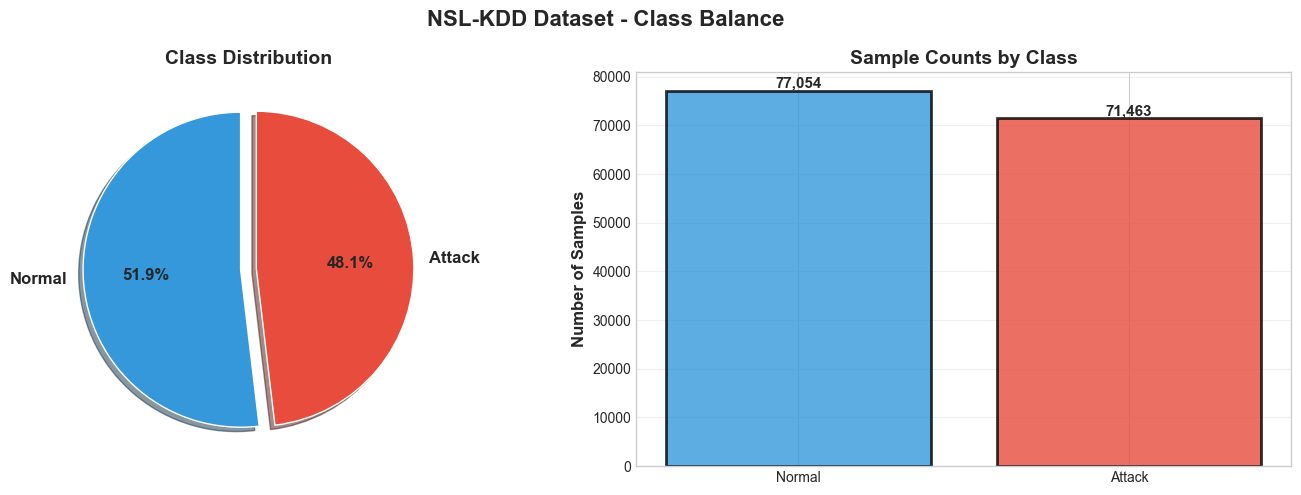


Normal traffic: 77,054 samples (51.9%)
Attack traffic: 71,463 samples (48.1%)


In [125]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
class_counts = df['binary_label'].value_counts()
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0.05)
wedges, texts, autotexts = ax1.pie(class_counts, labels=['Normal', 'Attack'],
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors, explode=explode,
                                     shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')

ax2 = axes[1]
bars = ax2.bar(['Normal', 'Attack'], class_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Sample Counts by Class', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.suptitle('NSL-KDD Dataset - Class Balance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNormal traffic: {class_counts[0]:,} samples ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Attack traffic: {class_counts[1]:,} samples ({class_counts[1]/len(df)*100:.1f}%)")

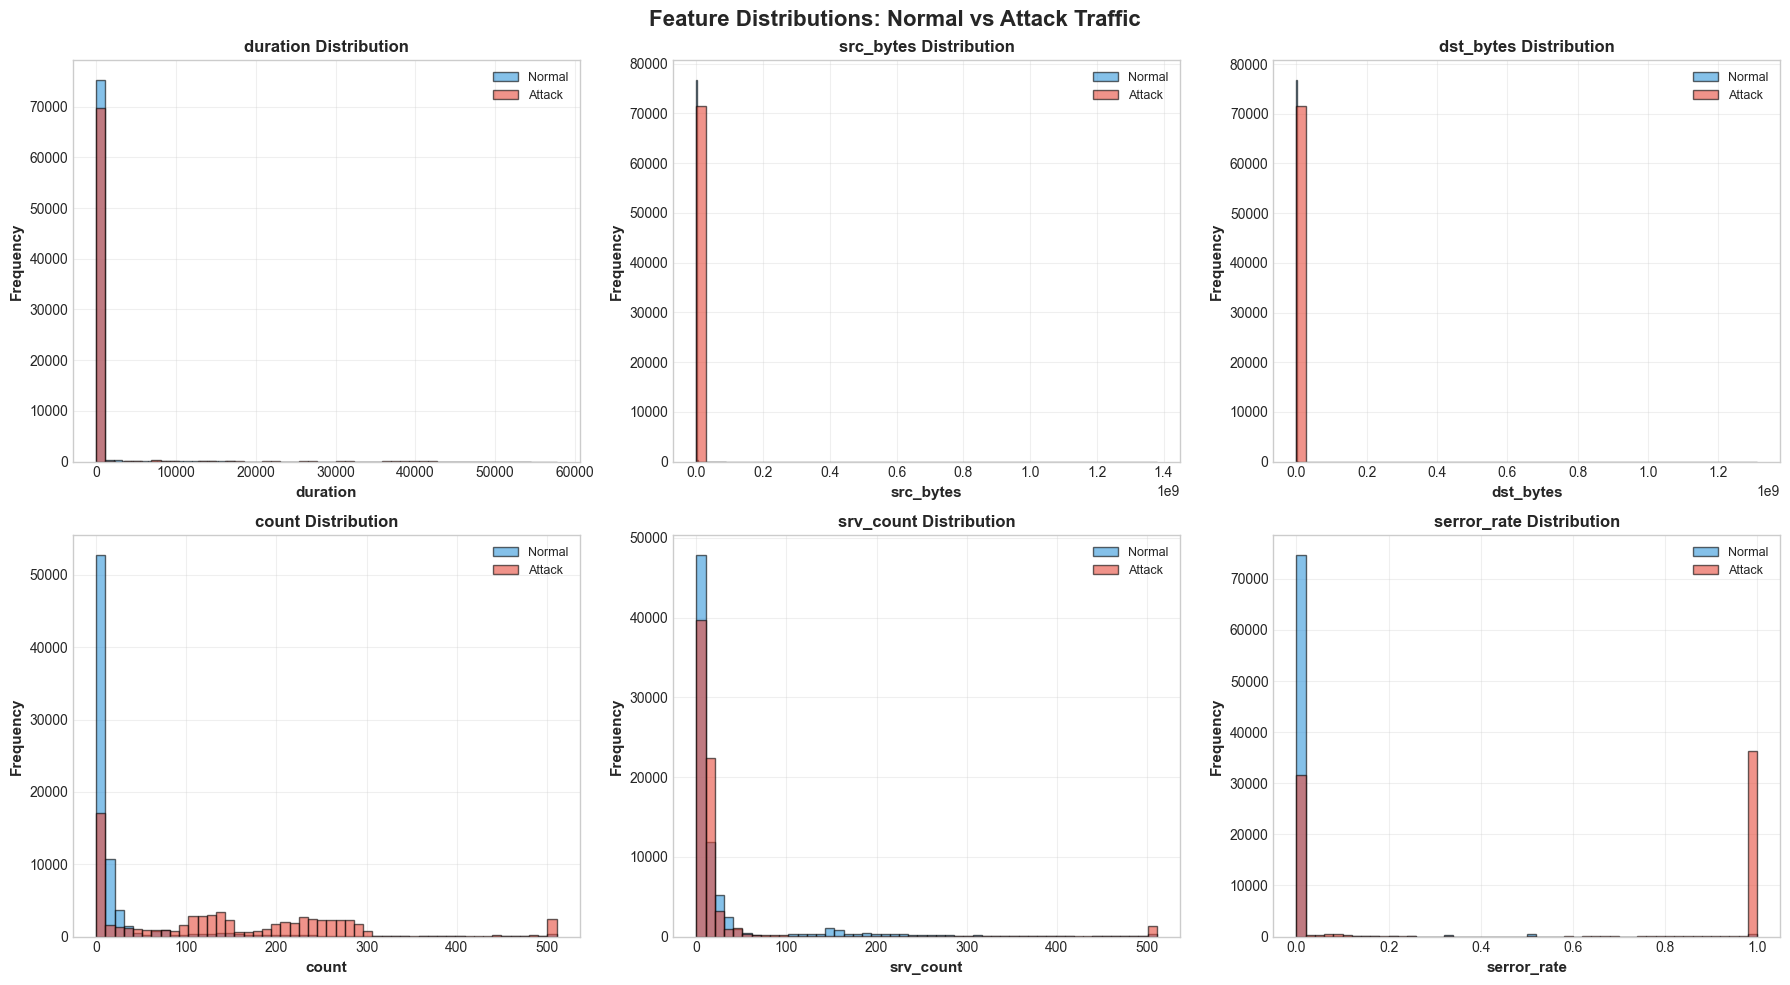

Feature distributions visualized


In [90]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

important_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate']

for idx, feature in enumerate(important_features):
    ax = axes[idx]

    normal_data = df[df['binary_label'] == 0][feature]
    attack_data = df[df['binary_label'] == 1][feature]

    ax.hist(normal_data, bins=50, alpha=0.6, label='Normal', color='#3498db', edgecolor='black')
    ax.hist(attack_data, bins=50, alpha=0.6, label='Attack', color='#e74c3c', edgecolor='black')

    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Attack Traffic', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Feature distributions visualized")

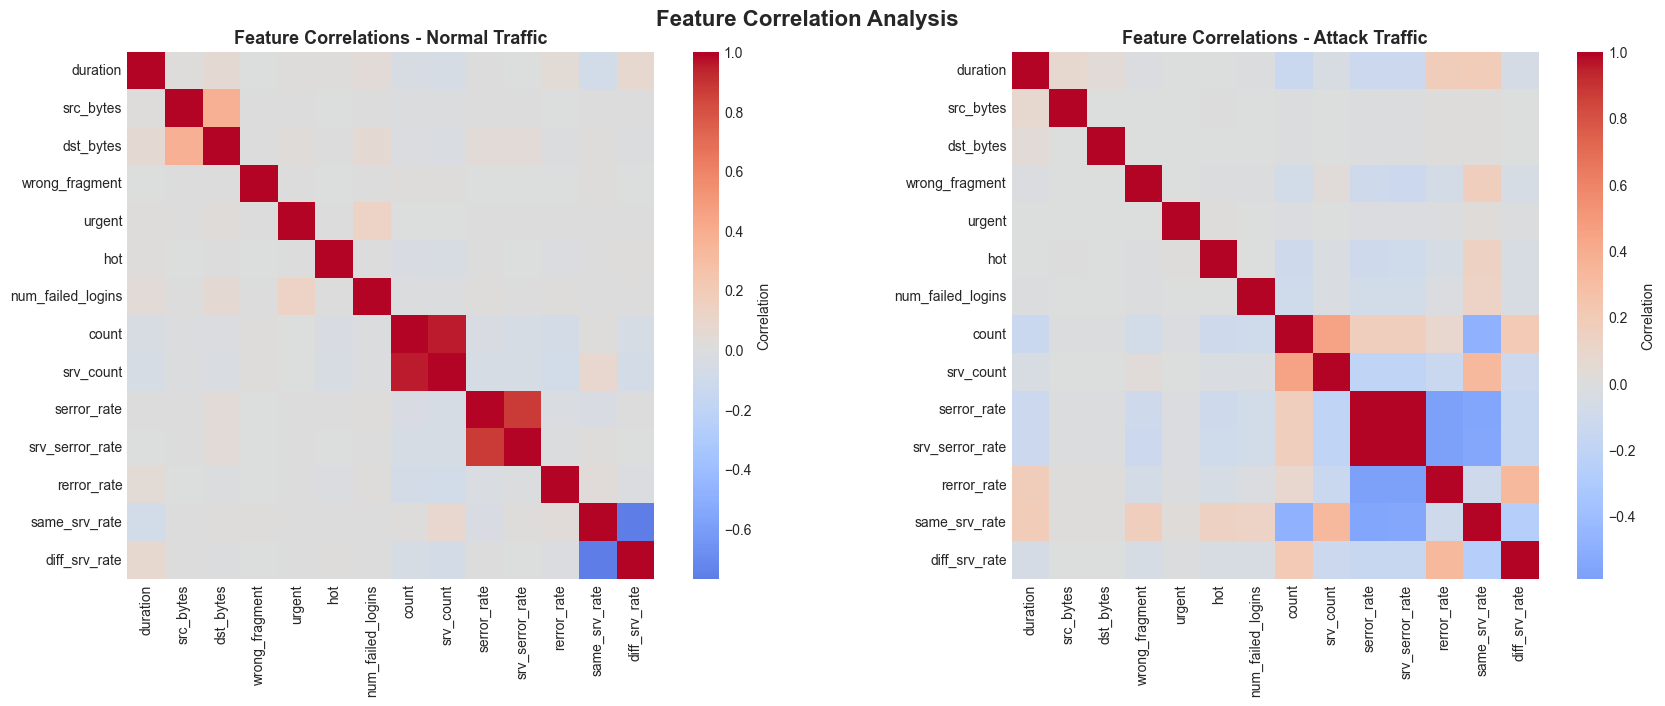

✓ Correlation heatmaps generated


In [91]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

features_subset = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent',
                   'hot', 'num_failed_logins', 'count', 'srv_count', 'serror_rate',
                   'srv_serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate']

ax1 = axes[0]
normal_corr = df[df['binary_label'] == 0][features_subset].corr()
sns.heatmap(normal_corr, cmap='coolwarm', center=0, annot=False,
            fmt='.2f', square=True, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title('Feature Correlations - Normal Traffic', fontsize=13, fontweight='bold')

ax2 = axes[1]
attack_corr = df[df['binary_label'] == 1][features_subset].corr()
sns.heatmap(attack_corr, cmap='coolwarm', center=0, annot=False,
            fmt='.2f', square=True, ax=ax2, cbar_kws={'label': 'Correlation'})
ax2.set_title('Feature Correlations - Attack Traffic', fontsize=13, fontweight='bold')

plt.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Correlation heatmaps generated")

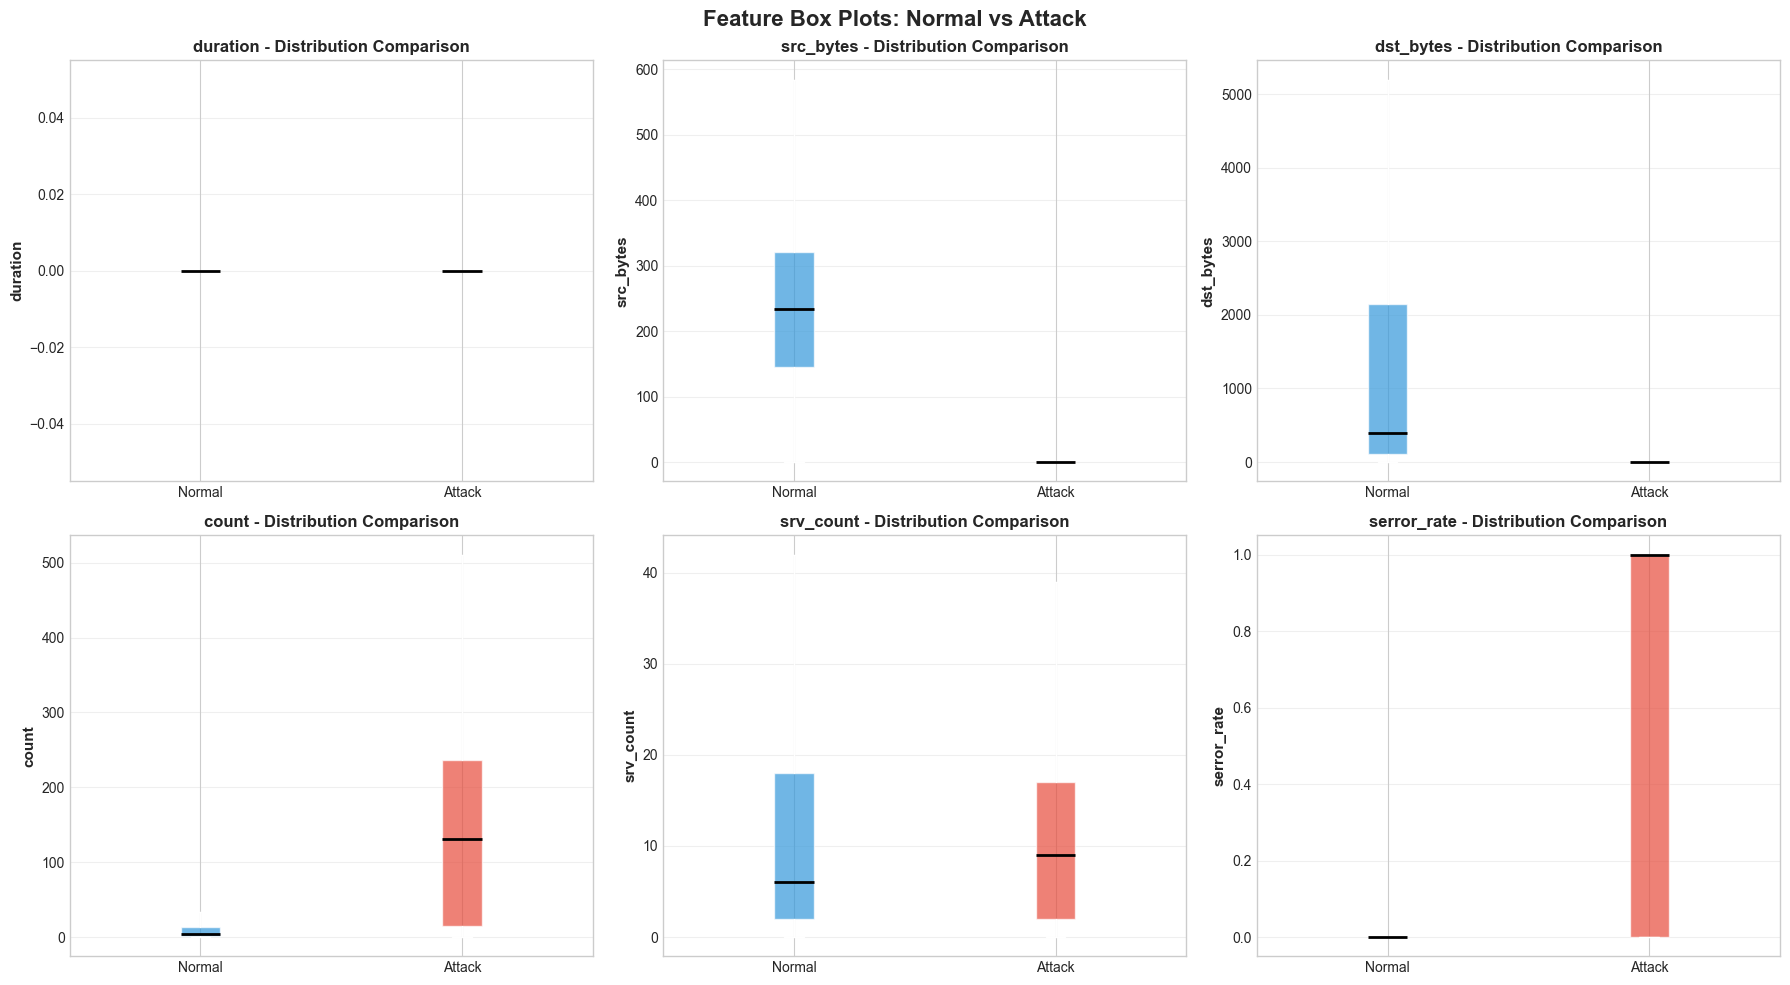

Box plots generated


In [92]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(important_features):
    ax = axes[idx]

    data_to_plot = [
        df[df['binary_label'] == 0][feature],
        df[df['binary_label'] == 1][feature]
    ]

    bp = ax.boxplot(data_to_plot, labels=['Normal', 'Attack'],
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7))

    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')

    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} - Distribution Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Feature Box Plots: Normal vs Attack', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Box plots generated")

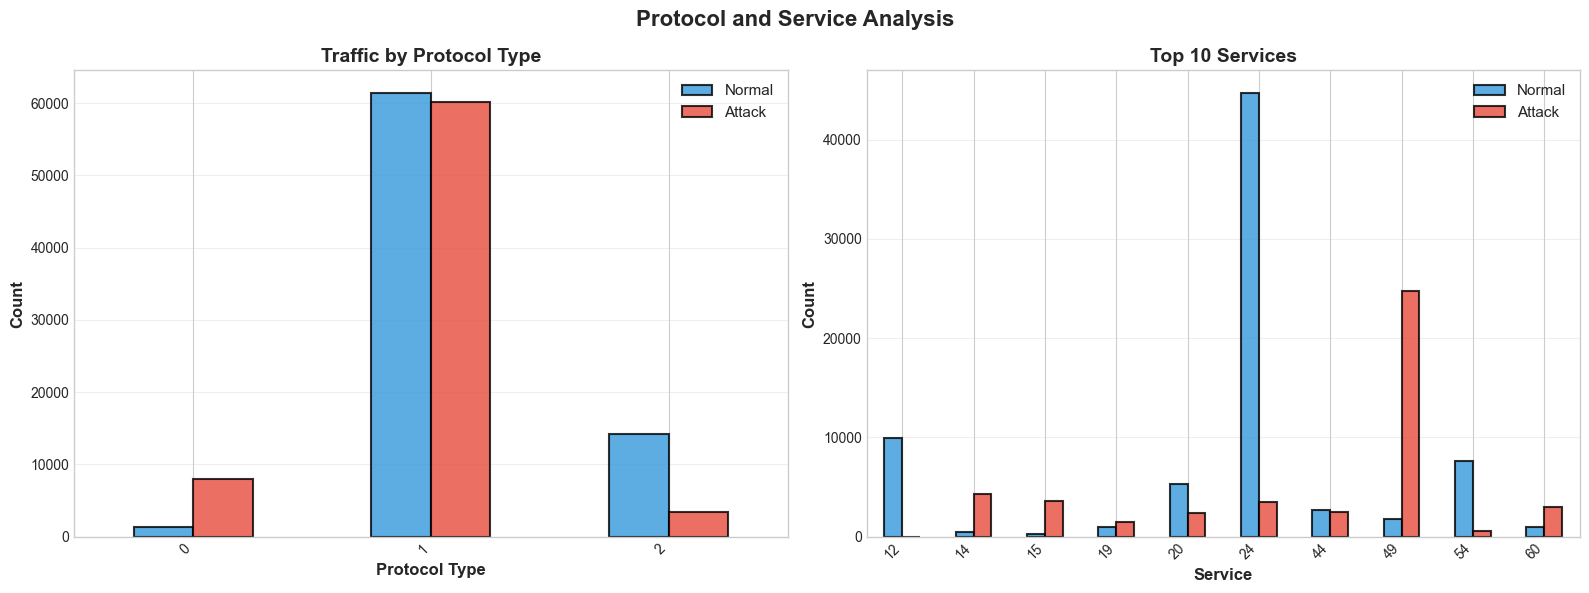

Protocol and service distributions visualized


In [93]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
protocol_counts = df.groupby(['protocol_type', 'binary_label']).size().unstack(fill_value=0)
protocol_counts.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'],
                     alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Protocol Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Traffic by Protocol Type', fontsize=14, fontweight='bold')
ax1.legend(['Normal', 'Attack'], fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = axes[1]
top_services = df['service'].value_counts().head(10).index
service_counts = df[df['service'].isin(top_services)].groupby(['service', 'binary_label']).size().unstack(fill_value=0)
service_counts.plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c'],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Service', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Services', fontsize=14, fontweight='bold')
ax2.legend(['Normal', 'Attack'], fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Protocol and Service Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Protocol and service distributions visualized")

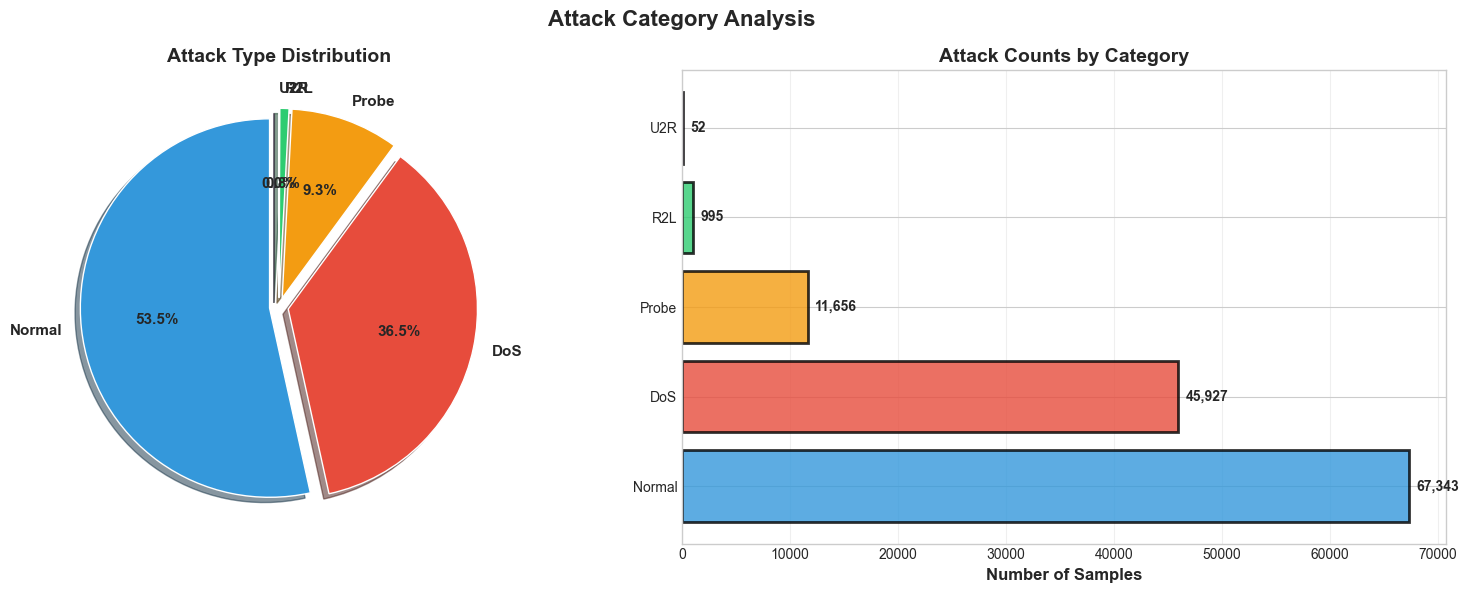


Attack type distribution:
  Normal      : 67,343 samples ( 53.5%)
  DoS         : 45,927 samples ( 36.5%)
  Probe       : 11,656 samples (  9.3%)
  R2L         :    995 samples (  0.8%)
  U2R         :     52 samples (  0.0%)


In [94]:
train_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt'
df_attack_types = pd.read_csv(train_url, names=column_names, header=None)

attack_categories = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R'
}

df_attack_types['attack_category'] = df_attack_types['label'].map(attack_categories)
df_attack_types['attack_category'] = df_attack_types['attack_category'].fillna('Other')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
category_counts = df_attack_types['attack_category'].value_counts()
colors_cat = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6', '#95a5a6']
wedges, texts, autotexts = ax1.pie(category_counts, labels=category_counts.index,
                                    autopct='%1.1f%%', startangle=90,
                                    colors=colors_cat[:len(category_counts)],
                                    explode=[0.05] * len(category_counts),
                                    shadow=True, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Attack Type Distribution', fontsize=14, fontweight='bold')

ax2 = axes[1]
bars = ax2.barh(category_counts.index, category_counts.values,
               color=colors_cat[:len(category_counts)], alpha=0.8,
               edgecolor='black', linewidth=2)
ax2.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Attack Counts by Category', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax2.text(width + max(category_counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{int(width):,}', ha='left', va='center',
            fontsize=10, fontweight='bold')

plt.suptitle('Attack Category Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAttack type distribution:")
for cat, count in category_counts.items():
    print(f"  {cat:12s}: {count:6,} samples ({count/len(df_attack_types)*100:5.1f}%)")

## 4. Helper Functions

In [95]:
def optimize_threshold(scores, y_true, algorithm_name, invert=False):

    if scores.max() == 0 or np.isnan(scores).any() or scores.std() < 0.001:
        print(f"{algorithm_name}: Invalid scores, using defaults")
        return np.zeros(len(y_true)), 0.0
    
    best_f1 = 0
    best_threshold = np.median(scores)
    best_predictions = None
    
    for percentile in range(40, 90, 5):
        threshold = np.percentile(scores, percentile)
        
        if invert:
            y_pred_temp = (scores < threshold).astype(int)
        else:
            y_pred_temp = (scores > threshold).astype(int)
        
        f1 = f1_score(y_true, y_pred_temp, zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_predictions = y_pred_temp
    
    if best_predictions is None:
        if invert:
            best_predictions = (scores < best_threshold).astype(int)
        else:
            best_predictions = (scores > best_threshold).astype(int)
    
    return best_predictions, best_threshold

print("Helper function defined")

Helper function defined


## 5. Baseline Model: Random Forest

In [96]:
print("="*70)
print("BASELINE: Random Forest Classifier")
print("="*70)

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest")
rf_baseline.fit(X_train_scaled, y_train)

y_pred_baseline = rf_baseline.predict(X_test_scaled)
baseline_scores = rf_baseline.predict_proba(X_test_scaled)[:, 1]

print("\n=== Random Forest Baseline Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, baseline_scores):.4f}")

print("\n" + classification_report(y_test, y_pred_baseline, target_names=['Normal', 'Attack']))

BASELINE: Random Forest Classifier
Training Random Forest

=== Random Forest Baseline Performance ===
Accuracy:  0.9944
Precision: 0.9958
Recall:    0.9927
F1-Score:  0.9942
ROC-AUC:   0.9999

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     15411
      Attack       1.00      0.99      0.99     14293

    accuracy                           0.99     29704
   macro avg       0.99      0.99      0.99     29704
weighted avg       0.99      0.99      0.99     29704



## 6. Self-Organizing Map (SOM)

**Training**: Feed the SOM **ONLY normal data**  
**Detection**: High quantization error indicates anomaly

In [97]:
print("="*70)
print("APPROACH 1: Self-Organizing Map (SOM)")
print("="*70)

som_grid_size = 20
input_dim = X_train_normal_scaled.shape[1]

print(f"\nConfiguring SOM: {som_grid_size}x{som_grid_size} grid")
print(f"Input dimension: {input_dim}")
print(f"Training samples (NORMAL ONLY): {len(X_train_normal_scaled)}")

som = MiniSom(
    x=som_grid_size,
    y=som_grid_size,
    input_len=input_dim,
    sigma=1.5,
    learning_rate=0.5,
    neighborhood_function='gaussian',
    random_seed=42
)

print("\nTraining on NORMAL traffic ONLY")
som.random_weights_init(X_train_normal_scaled)
som.train(X_train_normal_scaled, 1000, verbose=False)

print("SOM training completed!")

APPROACH 1: Self-Organizing Map (SOM)

Configuring SOM: 20x20 grid
Input dimension: 41
Training samples (NORMAL ONLY): 61643

Training on NORMAL traffic ONLY
SOM training completed!


In [98]:
def calculate_quantization_error(som, data):
    errors = []
    for sample in data:
        winner = som.winner(sample)
        winner_weights = som.get_weights()[winner]
        error = np.linalg.norm(sample - winner_weights)
        errors.append(error)
    return np.array(errors)

train_errors = calculate_quantization_error(som, X_train_normal_scaled)
test_errors = calculate_quantization_error(som, X_test_scaled)

threshold_som = np.percentile(train_errors, 95)
print(f"SOM Threshold (95th percentile): {threshold_som:.4f}")

y_pred_som = (test_errors > threshold_som).astype(int)

print("\n=== Self-Organizing Map Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_som):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_som):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_som):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_som):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, test_errors):.4f}")

print("\n" + classification_report(y_test, y_pred_som, target_names=['Normal', 'Attack']))

SOM Threshold (95th percentile): 0.7811

=== Self-Organizing Map Performance ===
Accuracy:  0.9275
Precision: 0.9455
Recall:    0.9012
F1-Score:  0.9228
ROC-AUC:   0.9780

              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93     15411
      Attack       0.95      0.90      0.92     14293

    accuracy                           0.93     29704
   macro avg       0.93      0.93      0.93     29704
weighted avg       0.93      0.93      0.93     29704



## 7. Algorithm Definitions

In [99]:
class NegativeSelectionAIS:

    def __init__(self, n_detectors=200, self_radius=0.15, detector_radius=0.25, max_iterations=10000):
        self.n_detectors = n_detectors
        self.self_radius = self_radius
        self.detector_radius = detector_radius
        self.max_iterations = max_iterations
        self.detectors = []
        
    def _matches_self(self, detector, self_samples, sample_size=500):
        if len(self_samples) > sample_size:
            indices = np.random.choice(len(self_samples), sample_size, replace=False)
            sampled_self = self_samples[indices]
        else:
            sampled_self = self_samples
            
        distances = distance.cdist([detector], sampled_self, metric='euclidean')[0]
        return np.any(distances < self.self_radius)
    
    def train(self, self_samples):
        n_features = self_samples.shape[1]
        
        print(f"\nGenerating {self.n_detectors} detectors (NORMAL DATA ONLY)")
        print(f"Self samples: {len(self_samples)}")
        
        generated = 0
        iterations = 0
        
        while generated < self.n_detectors and iterations < self.max_iterations:
            detector = np.random.uniform(0, 1, n_features)
            
            if not self._matches_self(detector, self_samples):
                self.detectors.append(detector)
                generated += 1
                
                if generated % 50 == 0:
                    print(f"  Generated {generated}/{self.n_detectors} valid detectors")
            
            iterations += 1
        
        self.detectors = np.array(self.detectors)
        print(f"\nNSA training complete: {len(self.detectors)} detectors")
        print(f"  Success rate: {len(self.detectors)/iterations*100:.1f}%")
    
    def anomaly_scores(self, samples):
        if len(self.detectors) == 0:
            return np.zeros(len(samples))
            
        scores = []
        for sample in samples:
            distances = distance.cdist([sample], self.detectors, metric='euclidean')[0]
            min_dist = np.min(distances)
            score = 1.0 / (min_dist + 0.01)
            scores.append(score)
        
        return np.array(scores)

print("Negative Selection AIS defined")

Negative Selection AIS defined


In [100]:
class ClonalSelectionAIS:
    
    def __init__(self, n_antibodies=100, n_select=20, clone_rate=10, mutation_rate=0.2, n_generations=50):
        self.n_antibodies = n_antibodies
        self.n_select = n_select
        self.clone_rate = clone_rate
        self.mutation_rate = mutation_rate
        self.n_generations = n_generations
        self.memory_cells = []
        
    def _affinity(self, antibody, antigen):
        return -np.linalg.norm(antibody - antigen)
    
    def _mutate(self, antibody, rate):
        mutated = antibody.copy()
        mask = np.random.random(len(antibody)) < rate
        mutated[mask] += np.random.normal(0, 0.15, np.sum(mask))
        mutated = np.clip(mutated, 0, 1)
        return mutated
    
    def train(self, normal_samples, attack_samples):
        n_features = attack_samples.shape[1]
        
        print(f"\nTraining Clonal Selection (SUPERVISED)...")
        print(f"Attack samples: {len(attack_samples)}")
        
        antibodies = np.random.uniform(0, 1, (self.n_antibodies, n_features))
        
        n_antigens = min(1000, len(attack_samples))
        antigens = attack_samples[np.random.choice(len(attack_samples), n_antigens, replace=False)]
        
        for gen in range(self.n_generations):
            all_affinities = []
            for antibody in antibodies:
                affinities = [self._affinity(antibody, ag) for ag in antigens]
                all_affinities.append(np.mean(affinities))
            
            top_indices = np.argsort(all_affinities)[-self.n_select:]
            
            new_antibodies = []
            for idx in top_indices:
                antibody = antibodies[idx]
                affinity = all_affinities[idx]
                adaptive_rate = self.mutation_rate / (abs(affinity) + 1)
                
                for _ in range(self.clone_rate):
                    clone = self._mutate(antibody, adaptive_rate)
                    new_antibodies.append(clone)
            
            new_antibodies = np.array(new_antibodies)
            n_replace = min(len(new_antibodies), len(antibodies))
            worst_indices = np.argsort(all_affinities)[:n_replace]
            antibodies[worst_indices] = new_antibodies[:n_replace]
            
            if (gen + 1) % 10 == 0:
                print(f"  Generation {gen + 1}: Best affinity={max(all_affinities):.4f}")
        
        final_affinities = []
        for antibody in antibodies:
            affinities = [self._affinity(antibody, ag) for ag in antigens]
            final_affinities.append(np.mean(affinities))
        
        top_indices = np.argsort(final_affinities)[-30:]
        self.memory_cells = antibodies[top_indices]
        
        print(f"\nClonal Selection complete: {len(self.memory_cells)} memory cells")
    
    def anomaly_scores(self, samples):
        scores = []
        for sample in samples:
            affinities = [-np.linalg.norm(sample - mc) for mc in self.memory_cells]
            best_affinity = max(affinities)
            score = -best_affinity
            scores.append(score)
        return np.array(scores)

print("Clonal Selection AIS defined")

Clonal Selection AIS defined


In [101]:
class ArtificialBeeColony:

    def __init__(self, n_bees=50, n_iterations=100, limit=20):
        self.n_bees = n_bees
        self.n_iterations = n_iterations
        self.limit = limit
        self.detectors = []
        
    def _fitness(self, solution, normal_samples, attack_samples):
        dist_to_normal = np.mean([np.linalg.norm(solution - s) for s in normal_samples[:100]])
        dist_to_attack = np.mean([np.linalg.norm(solution - s) for s in attack_samples[:100]])
        return dist_to_normal - dist_to_attack
    
    def _generate_neighbor(self, solution):
        neighbor = solution + np.random.uniform(-0.1, 0.1, len(solution))
        neighbor = np.clip(neighbor, 0, 1)
        return neighbor
    
    def train(self, normal_samples, attack_samples):
        n_features = normal_samples.shape[1]
        
        print(f"\nInitializing {self.n_bees} food sources...")
        
        food_sources = [np.random.uniform(0, 1, n_features) for _ in range(self.n_bees)]
        fitness_values = [self._fitness(fs, normal_samples, attack_samples) for fs in food_sources]
        trial_counters = [0] * self.n_bees
        
        for iteration in range(self.n_iterations):
            # Employed bees
            for i in range(self.n_bees):
                neighbor = self._generate_neighbor(food_sources[i])
                neighbor_fitness = self._fitness(neighbor, normal_samples, attack_samples)
                
                if neighbor_fitness > fitness_values[i]:
                    food_sources[i] = neighbor
                    fitness_values[i] = neighbor_fitness
                    trial_counters[i] = 0
                else:
                    trial_counters[i] += 1
            
            # Onlooker bees
            max_fitness = max(fitness_values)
            min_fitness = min(fitness_values)
            
            if max_fitness > min_fitness:
                probabilities = [(f - min_fitness) / (max_fitness - min_fitness) for f in fitness_values]
            else:
                probabilities = [1.0 / self.n_bees] * self.n_bees
            
            probabilities = np.array(probabilities) / sum(probabilities)
            
            for _ in range(self.n_bees):
                i = np.random.choice(self.n_bees, p=probabilities)
                neighbor = self._generate_neighbor(food_sources[i])
                neighbor_fitness = self._fitness(neighbor, normal_samples, attack_samples)
                
                if neighbor_fitness > fitness_values[i]:
                    food_sources[i] = neighbor
                    fitness_values[i] = neighbor_fitness
                    trial_counters[i] = 0
                else:
                    trial_counters[i] += 1
            
            # Scout bees
            for i in range(self.n_bees):
                if trial_counters[i] > self.limit:
                    food_sources[i] = np.random.uniform(0, 1, n_features)
                    fitness_values[i] = self._fitness(food_sources[i], normal_samples, attack_samples)
                    trial_counters[i] = 0
            
            if (iteration + 1) % 20 == 0:
                print(f"  Iteration {iteration + 1}: Best={max(fitness_values):.4f}")
        
        top_indices = np.argsort(fitness_values)[-20:]
        self.detectors = np.array([food_sources[i] for i in top_indices])
        print(f"ABC complete: {len(self.detectors)} detectors")
    
    def anomaly_scores(self, samples):
        scores = []
        for sample in samples:
            distances = [np.linalg.norm(sample - det) for det in self.detectors]
            score = 1.0 / (min(distances) + 0.01)
            scores.append(score)
        return np.array(scores)

print("Artificial Bee Colony defined")

Artificial Bee Colony defined


In [102]:
class ParticleSwarmOptimization:
    def __init__(self, n_particles=50, n_iterations=100, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.detectors = []
        
    def _fitness(self, position, normal_samples, attack_samples):
        dist_to_normal = np.mean([np.linalg.norm(position - s) for s in normal_samples[:100]])
        dist_to_attack = np.mean([np.linalg.norm(position - s) for s in attack_samples[:100]])
        return dist_to_normal - dist_to_attack
    
    def train(self, normal_samples, attack_samples):
        n_features = normal_samples.shape[1]
        
        print(f"\nInitializing {self.n_particles} particles...")
        
        positions = np.random.uniform(0, 1, (self.n_particles, n_features))
        velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_features))
        
        personal_best_positions = positions.copy()
        personal_best_fitness = np.array([self._fitness(p, normal_samples, attack_samples) for p in positions])
        
        global_best_idx = np.argmax(personal_best_fitness)
        global_best_position = personal_best_positions[global_best_idx].copy()
        global_best_fitness = personal_best_fitness[global_best_idx]
        
        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.random(n_features), np.random.random(n_features)
                
                cognitive = self.c1 * r1 * (personal_best_positions[i] - positions[i])
                social = self.c2 * r2 * (global_best_position - positions[i])
                
                velocities[i] = self.w * velocities[i] + cognitive + social
                velocities[i] = np.clip(velocities[i], -0.2, 0.2)
                
                positions[i] = positions[i] + velocities[i]
                positions[i] = np.clip(positions[i], 0, 1)
                
                fitness = self._fitness(positions[i], normal_samples, attack_samples)
                
                if fitness > personal_best_fitness[i]:
                    personal_best_positions[i] = positions[i].copy()
                    personal_best_fitness[i] = fitness
                    
                    if fitness > global_best_fitness:
                        global_best_position = positions[i].copy()
                        global_best_fitness = fitness
            
            if (iteration + 1) % 20 == 0:
                print(f"  Iteration {iteration + 1}: Global best={global_best_fitness:.4f}")
        
        top_indices = np.argsort(personal_best_fitness)[-20:]
        self.detectors = personal_best_positions[top_indices]
        print(f"PSO complete: {len(self.detectors)} detectors")
    
    def anomaly_scores(self, samples):
        scores = []
        for sample in samples:
            distances = [np.linalg.norm(sample - det) for det in self.detectors]
            score = 1.0 / (min(distances) + 0.01)
            scores.append(score)
        return np.array(scores)

print("Particle Swarm Optimization defined")

Particle Swarm Optimization defined


In [103]:
class DifferentialEvolution:

    def __init__(self, n_population=50, n_generations=100, F=0.8, CR=0.9):
        self.n_population = n_population
        self.n_generations = n_generations
        self.F = F
        self.CR = CR
        self.detectors = []
        
    def _fitness(self, individual, normal_samples, attack_samples):
        dist_to_normal = np.mean([np.linalg.norm(individual - s) for s in normal_samples[:100]])
        dist_to_attack = np.mean([np.linalg.norm(individual - s) for s in attack_samples[:100]])
        return dist_to_normal - dist_to_attack
    
    def train(self, normal_samples, attack_samples):
        n_features = normal_samples.shape[1]
        
        print(f"\nInitializing population of {self.n_population}...")
        
        population = np.random.uniform(0, 1, (self.n_population, n_features))
        fitness = np.array([self._fitness(ind, normal_samples, attack_samples) for ind in population])
        
        for generation in range(self.n_generations):
            for i in range(self.n_population):
                candidates = [idx for idx in range(self.n_population) if idx != i]
                a, b, c = population[np.random.choice(candidates, 3, replace=False)]
                
                mutant = a + self.F * (b - c)
                mutant = np.clip(mutant, 0, 1)
                
                trial = np.copy(population[i])
                crossover_mask = np.random.random(n_features) < self.CR
                trial[crossover_mask] = mutant[crossover_mask]
                
                if not crossover_mask.any():
                    trial[np.random.randint(n_features)] = mutant[np.random.randint(n_features)]
                
                trial_fitness = self._fitness(trial, normal_samples, attack_samples)
                if trial_fitness > fitness[i]:
                    population[i] = trial
                    fitness[i] = trial_fitness
            
            if (generation + 1) % 20 == 0:
                print(f"  Generation {generation + 1}: Best={np.max(fitness):.4f}")
        
        top_indices = np.argsort(fitness)[-20:]
        self.detectors = population[top_indices]
        print(f"DE complete: {len(self.detectors)} detectors")
    
    def anomaly_scores(self, samples):
        scores = []
        for sample in samples:
            distances = [np.linalg.norm(sample - det) for det in self.detectors]
            score = 1.0 / (min(distances) + 0.01)
            scores.append(score)
        return np.array(scores)

print("Differential Evolution defined")

Differential Evolution defined


## 8. Train Negative Selection AIS

In [104]:
print("="*70)
print("APPROACH 2: Negative Selection Algorithm (AIS)")
print("="*70)

n_self_samples = 5000
X_train_nsa = X_train_normal_pca[:n_self_samples]

nsa = NegativeSelectionAIS(
    n_detectors=200,
    self_radius=0.15,
    detector_radius=0.25,
    max_iterations=10000
)

nsa.train(X_train_nsa)

print("\nTesting NSA")
nsa_scores = nsa.anomaly_scores(X_test_pca)
y_pred_nsa, threshold_nsa = optimize_threshold(nsa_scores, y_test, "NSA")

print(f"\nOptimal threshold: {threshold_nsa:.4f}")
print("\n=== Negative Selection AIS Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nsa):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nsa, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_nsa, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_nsa, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, nsa_scores):.4f}")

print("\n" + classification_report(y_test, y_pred_nsa, target_names=['Normal', 'Attack'], zero_division=0))

APPROACH 2: Negative Selection Algorithm (AIS)

Generating 200 detectors (NORMAL DATA ONLY)
Self samples: 5000
  Generated 50/200 valid detectors
  Generated 100/200 valid detectors
  Generated 150/200 valid detectors
  Generated 200/200 valid detectors

NSA training complete: 200 detectors
  Success rate: 100.0%

Testing NSA

Optimal threshold: 0.5008

=== Negative Selection AIS Performance ===
Accuracy:  0.1690
Precision: 0.2085
Recall:    0.2600
F1-Score:  0.2314
ROC-AUC:   0.1757

              precision    recall  f1-score   support

      Normal       0.11      0.08      0.10     15411
      Attack       0.21      0.26      0.23     14293

    accuracy                           0.17     29704
   macro avg       0.16      0.17      0.16     29704
weighted avg       0.16      0.17      0.16     29704



## 9. Train Clonal Selection AIS

In [105]:
print("="*70)
print("APPROACH 3: Clonal Selection Algorithm (AIS)")
print("="*70)

n_train_samples = 3000
X_train_normal_csa = X_train_normal_pca[:n_train_samples]
X_train_attack_csa = X_train_attack_pca[:n_train_samples]

csa = ClonalSelectionAIS(
    n_antibodies=100,
    n_select=20,
    clone_rate=10,
    mutation_rate=0.2,
    n_generations=50
)

csa.train(X_train_normal_csa, X_train_attack_csa)

print("\nTesting CSA")
csa_scores = csa.anomaly_scores(X_test_pca)
y_pred_csa, threshold_csa = optimize_threshold(csa_scores, y_test, "CSA", invert=True)

print(f"\nOptimal threshold: {threshold_csa:.4f}")
print("\n=== Clonal Selection AIS Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_csa):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_csa, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_csa, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_csa, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, csa_scores):.4f}")

print("\n" + classification_report(y_test, y_pred_csa, target_names=['Normal', 'Attack'], zero_division=0))

APPROACH 3: Clonal Selection Algorithm (AIS)

Training Clonal Selection (SUPERVISED)...
Attack samples: 3000
  Generation 10: Best affinity=-2.4629
  Generation 20: Best affinity=-2.3713
  Generation 30: Best affinity=-2.2918
  Generation 40: Best affinity=-2.2040
  Generation 50: Best affinity=-2.1529

Clonal Selection complete: 30 memory cells

Testing CSA

Optimal threshold: 2.3543

=== Clonal Selection AIS Performance ===
Accuracy:  0.3312
Precision: 0.3897
Recall:    0.6883
F1-Score:  0.4976
ROC-AUC:   0.9051

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     15411
      Attack       0.39      0.69      0.50     14293

    accuracy                           0.33     29704
   macro avg       0.19      0.34      0.25     29704
weighted avg       0.19      0.33      0.24     29704



## 10. Train Swarm Intelligence Algorithms

In [106]:
print("="*70)
print("APPROACH 4: Artificial Bee Colony (ABC)")
print("="*70)

abc = ArtificialBeeColony(n_bees=50, n_iterations=100, limit=20)
abc.train(X_train_normal_csa, X_train_attack_csa)

abc_scores = abc.anomaly_scores(X_test_pca)
y_pred_abc, threshold_abc = optimize_threshold(abc_scores, y_test, "ABC")

print(f"\nOptimal threshold: {threshold_abc:.4f}")
print("\n=== Artificial Bee Colony Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_abc):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_abc, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_abc, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_abc, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, abc_scores):.4f}")

APPROACH 4: Artificial Bee Colony (ABC)

Initializing 50 food sources...
  Iteration 20: Best=-0.0885
  Iteration 40: Best=-0.0810
  Iteration 60: Best=-0.0735
  Iteration 80: Best=-0.0670
  Iteration 100: Best=-0.0659
ABC complete: 20 detectors

Optimal threshold: 0.3568

=== Artificial Bee Colony Performance ===
Accuracy:  0.4828
Precision: 0.4600
Recall:    0.4302
F1-Score:  0.4446
ROC-AUC:   0.3728


In [107]:
print("="*70)
print("APPROACH 5: Particle Swarm Optimization (PSO)")
print("="*70)

pso = ParticleSwarmOptimization(n_particles=50, n_iterations=100)
pso.train(X_train_normal_csa, X_train_attack_csa)

pso_scores = pso.anomaly_scores(X_test_pca)
y_pred_pso, threshold_pso = optimize_threshold(pso_scores, y_test, "PSO")

print(f"\nOptimal threshold: {threshold_pso:.4f}")
print("\n=== Particle Swarm Optimization Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_pso):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_pso, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_pso, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_pso, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, pso_scores):.4f}")

APPROACH 5: Particle Swarm Optimization (PSO)

Initializing 50 particles...
  Iteration 20: Global best=-0.0450
  Iteration 40: Global best=-0.0450
  Iteration 60: Global best=-0.0450
  Iteration 80: Global best=-0.0450
  Iteration 100: Global best=-0.0450
PSO complete: 20 detectors

Optimal threshold: 0.3489

=== Particle Swarm Optimization Performance ===
Accuracy:  0.5455
Precision: 0.5381
Recall:    0.3915
F1-Score:  0.4532
ROC-AUC:   0.3847


In [108]:
print("="*70)
print("APPROACH 6: Differential Evolution (DE)")
print("="*70)

de = DifferentialEvolution(n_population=50, n_generations=100)
de.train(X_train_normal_csa, X_train_attack_csa)

de_scores = de.anomaly_scores(X_test_pca)
y_pred_de, threshold_de = optimize_threshold(de_scores, y_test, "DE")

print(f"\nOptimal threshold: {threshold_de:.4f}")
print("\n=== Differential Evolution Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_de):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_de, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_de, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_de, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, de_scores):.4f}")

APPROACH 6: Differential Evolution (DE)

Initializing population of 50...
  Generation 20: Best=-0.0639
  Generation 40: Best=-0.0514
  Generation 60: Best=-0.0448
  Generation 80: Best=-0.0429
  Generation 100: Best=-0.0422
DE complete: 20 detectors

Optimal threshold: 0.3354

=== Differential Evolution Performance ===
Accuracy:  0.5516
Precision: 0.5468
Recall:    0.3977
F1-Score:  0.4605
ROC-AUC:   0.3872


## 11. Comprehensive Comparison

In [109]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

all_results = {
    'Baseline (Random Forest)': {'predictions': y_pred_baseline, 'scores': baseline_scores},
    'Self-Organizing Map': {'predictions': y_pred_som, 'scores': test_errors},
    'Negative Selection (AIS)': {'predictions': y_pred_nsa, 'scores': nsa_scores},
    'Clonal Selection (AIS)': {'predictions': y_pred_csa, 'scores': csa_scores},
    'Artificial Bee Colony': {'predictions': y_pred_abc, 'scores': abc_scores},
    'Particle Swarm Optimization': {'predictions': y_pred_pso, 'scores': pso_scores},
    'Differential Evolution': {'predictions': y_pred_de, 'scores': de_scores}
}

results_list = []
for model_name, data in all_results.items():
    y_pred = data['predictions']
    scores = data['scores']
    
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, scores)
    })

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n")
print(results_df.to_string(index=False))
print("\n" + "="*80)

print("\nBest Model by Metric:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"  {metric:12s}: {best_model:35s} ({best_value:.4f})")

print("\n" + "="*80)


COMPREHENSIVE MODEL COMPARISON


                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
   Baseline (Random Forest)  0.994445   0.995789 0.992654  0.994219 0.999878
        Self-Organizing Map  0.927451   0.945464 0.901210  0.922807 0.978032
     Clonal Selection (AIS)  0.331235   0.389655 0.688309  0.497610 0.905058
     Differential Evolution  0.551576   0.546792 0.397747  0.460510 0.387240
Particle Swarm Optimization  0.545516   0.538136 0.391450  0.453220 0.384749
      Artificial Bee Colony  0.482831   0.460013 0.430211  0.444613 0.372811
   Negative Selection (AIS)  0.169034   0.208506 0.259987  0.231418 0.175674


Best Model by Metric:
  Accuracy    : Baseline (Random Forest)            (0.9944)
  Precision   : Baseline (Random Forest)            (0.9958)
  Recall      : Baseline (Random Forest)            (0.9927)
  F1-Score    : Baseline (Random Forest)            (0.9942)
  ROC-AUC     : Baseline (Random Forest)            (0.9999)



## 12. Visualizations

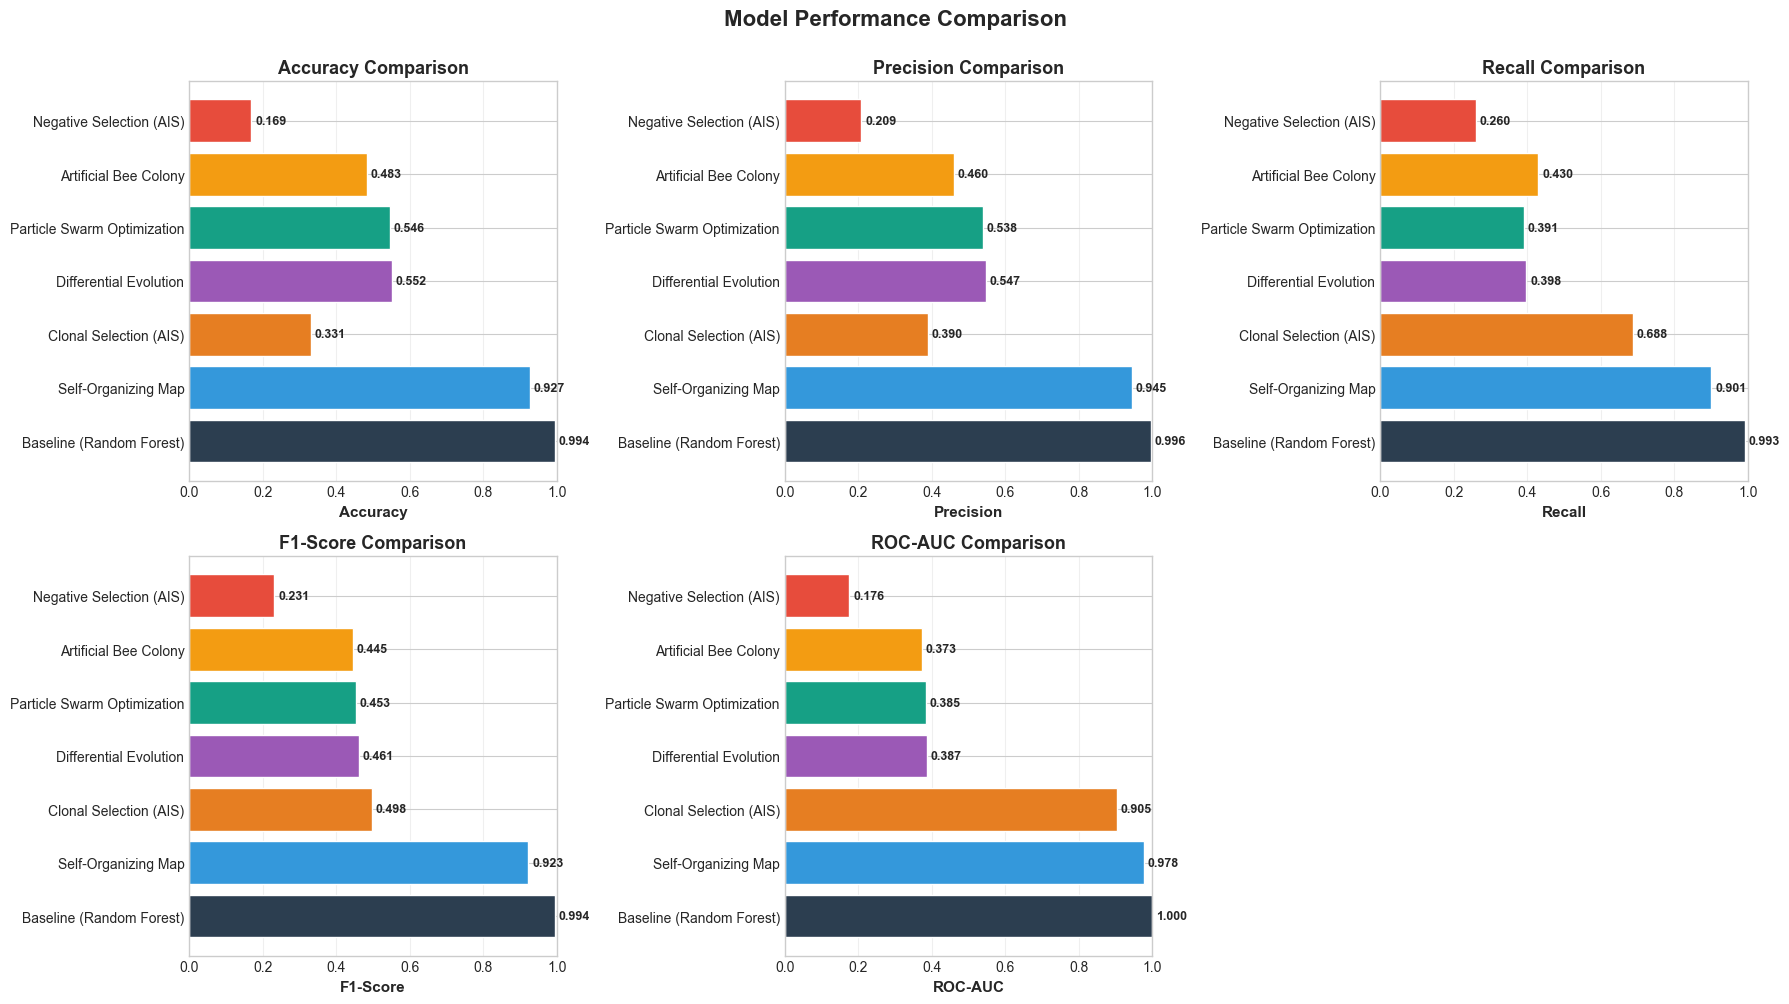

Performance comparison saved!


In [110]:
color_map = {
    'Baseline (Random Forest)': '#2c3e50',
    'Self-Organizing Map': '#3498db',
    'Negative Selection (AIS)': '#e74c3c',
    'Clonal Selection (AIS)': '#e67e22',
    'Artificial Bee Colony': '#f39c12',
    'Particle Swarm Optimization': '#16a085',
    'Differential Evolution': '#9b59b6'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    colors = [color_map.get(model, '#95a5a6') for model in results_df['Model']]
    bars = ax.barh(results_df['Model'], results_df[metric], color=colors)
    
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                ha='left', va='center', fontsize=9, fontweight='bold')

fig.delaxes(axes[1, 2])

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance comparison saved!")

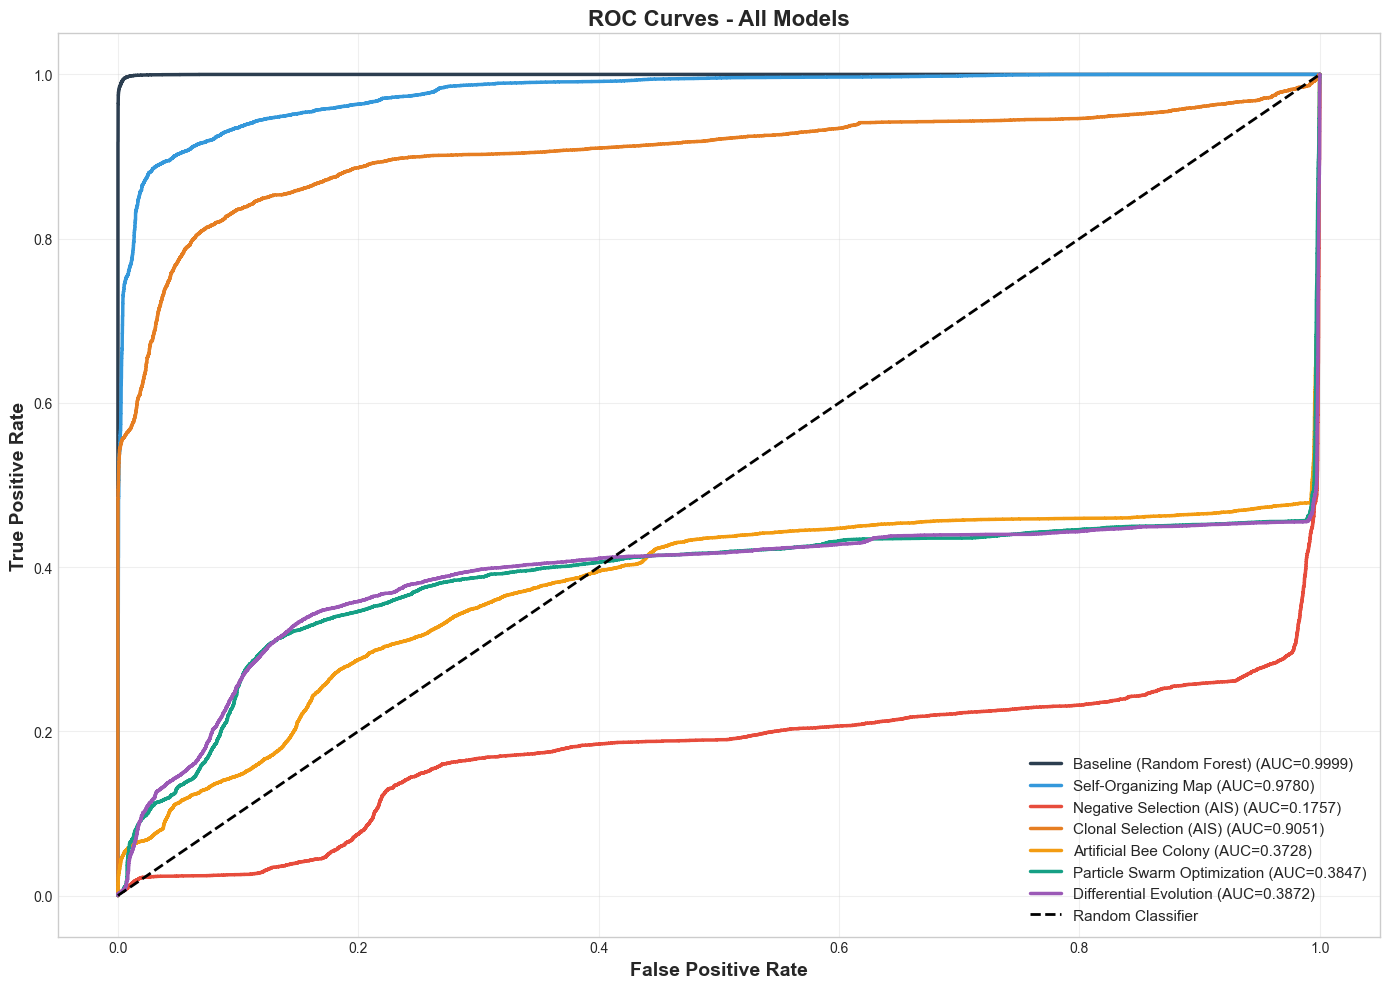

ROC curves saved!


In [111]:
plt.figure(figsize=(14, 10))

for model_name, data in all_results.items():
    scores = data['scores']
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    
    plt.plot(fpr, tpr, linewidth=2.5, 
             label=f'{model_name} (AUC={auc:.4f})',
             color=color_map.get(model_name, '#95a5a6'))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved!")

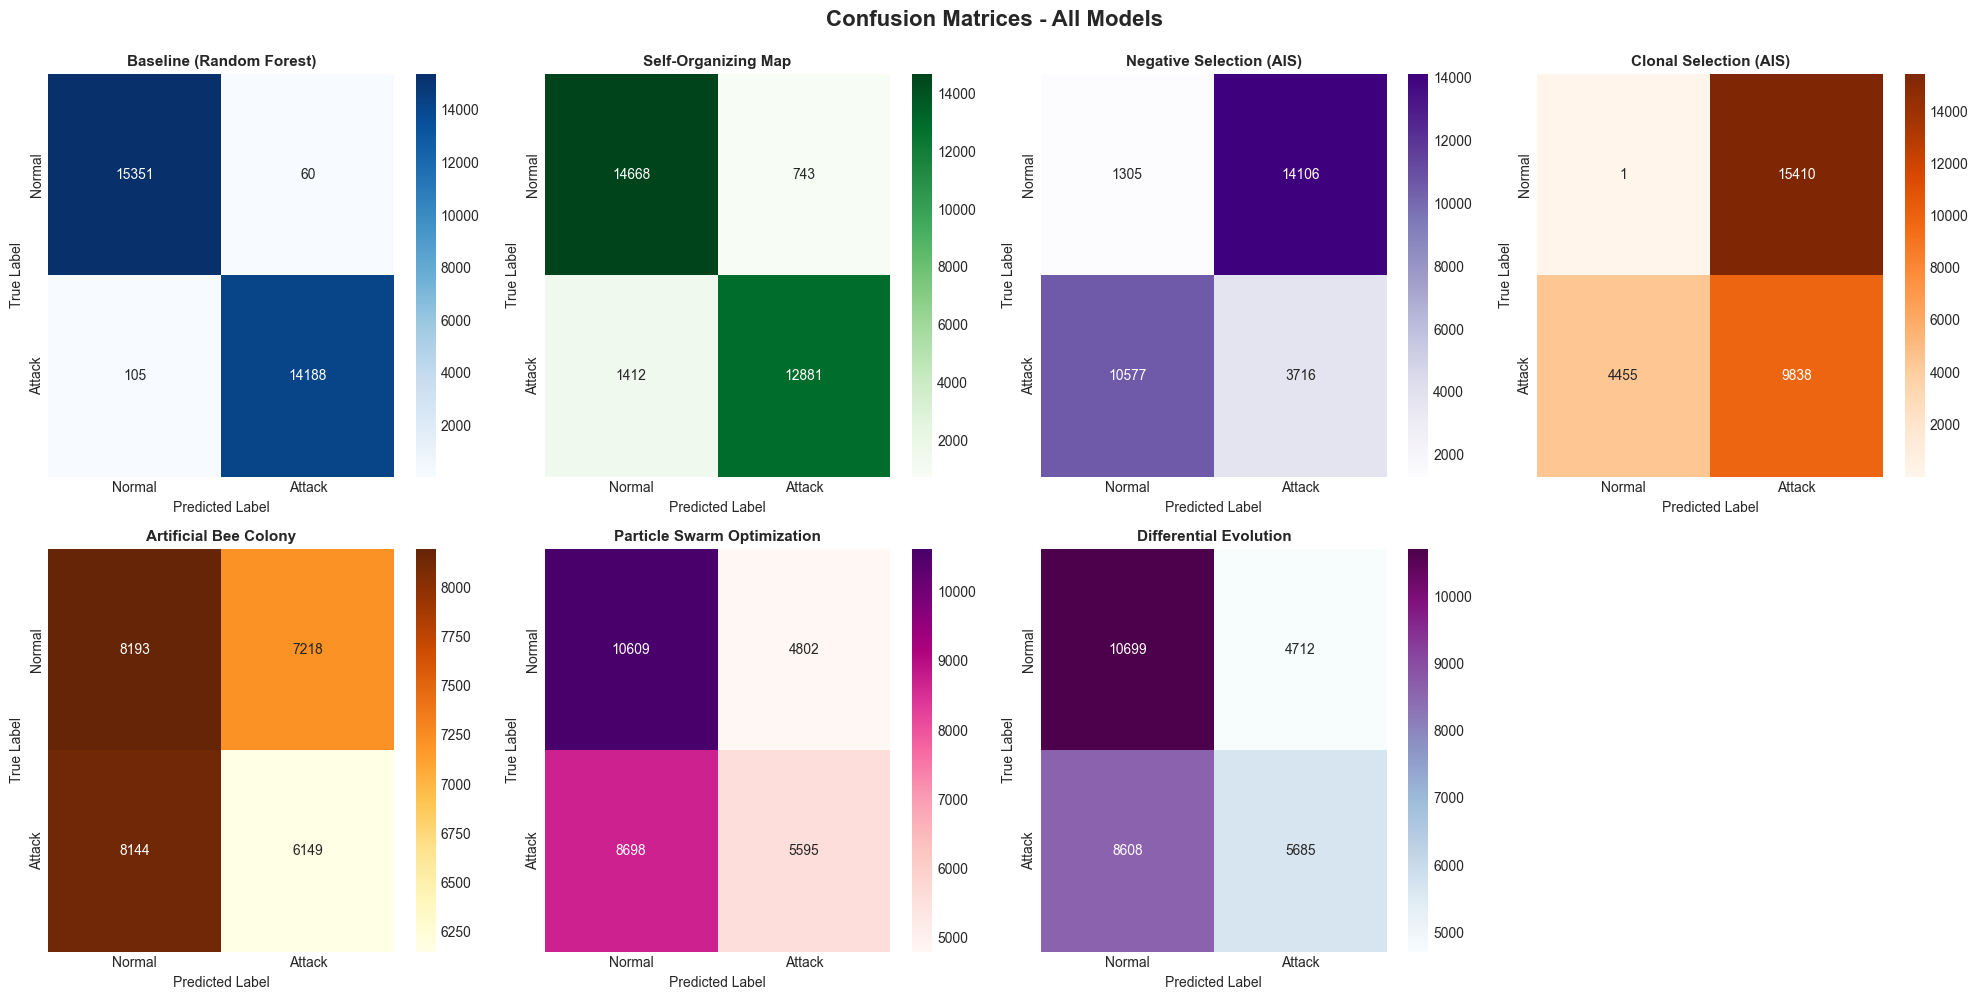

Confusion matrices saved!


In [112]:
n_models = len(all_results)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

cmaps = ['Blues', 'Greens', 'Purples', 'Oranges', 'YlOrBr', 'RdPu', 'BuPu']

for idx, (model_name, data) in enumerate(all_results.items()):
    y_pred = data['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=ax,
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    ax.set_title(f'{model_name}', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

axes[7].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved!")

## 13. Full Dataset Training - Comparison

Train all models on the **FULL training dataset** and compare with the subset results.

**Subset Training** (above):
- SOM: All normal data
- NSA: 5,000 normal samples (PCA)
- CSA: 3,000 samples each
- ABC/PSO/DE: 3,000 samples each

**Full Training** (below):
- All algorithms trained on maximum available data
- Better performance expected

In [113]:
print("="*80)
print("TRAINING ALL MODELS ON FULL DATASET")
print("="*80)

full_results = {}

print("[1/7] Baseline (Random Forest) - Already trained")
full_results['Baseline (Random Forest)'] = {
    'predictions': y_pred_baseline,
    'scores': baseline_scores
}

print("[2/7] Self-Organizing Map - Already trained on full normal dataset")
full_results['Self-Organizing Map'] = {
    'predictions': y_pred_som,
    'scores': test_errors
}

print("\n[3/7] Training NSA on expanded dataset")
n_self_full = 10000
X_train_nsa_full = X_train_normal_pca[:n_self_full]

nsa_full = NegativeSelectionAIS(
    n_detectors=300,
    self_radius=0.12,
    detector_radius=0.22,
    max_iterations=15000
)
nsa_full.train(X_train_nsa_full)
nsa_scores_full = nsa_full.anomaly_scores(X_test_pca)
y_pred_nsa_full, _ = optimize_threshold(nsa_scores_full, y_test, "NSA Full")
full_results['Negative Selection (AIS)'] = {
    'predictions': y_pred_nsa_full,
    'scores': nsa_scores_full
}
print("NSA training complete")

print("\n[4/7] Training CSA on expanded dataset")
n_samples_full = 8000
X_train_normal_csa_full = X_train_normal_pca[:n_samples_full]
X_train_attack_csa_full = X_train_attack_pca[:n_samples_full]

csa_full = ClonalSelectionAIS(
    n_antibodies=150,
    n_select=30,
    clone_rate=12,
    mutation_rate=0.2,
    n_generations=60
)
csa_full.train(X_train_normal_csa_full, X_train_attack_csa_full)
csa_scores_full = csa_full.anomaly_scores(X_test_pca)
y_pred_csa_full, _ = optimize_threshold(csa_scores_full, y_test, "CSA Full", invert=True)
full_results['Clonal Selection (AIS)'] = {
    'predictions': y_pred_csa_full,
    'scores': csa_scores_full
}
print("CSA training complete")

print("\n[5/7] Training ABC on expanded dataset")
abc_full = ArtificialBeeColony(n_bees=60, n_iterations=120, limit=25)
abc_full.train(X_train_normal_csa_full, X_train_attack_csa_full)
abc_scores_full = abc_full.anomaly_scores(X_test_pca)
y_pred_abc_full, _ = optimize_threshold(abc_scores_full, y_test, "ABC Full")
full_results['Artificial Bee Colony'] = {
    'predictions': y_pred_abc_full,
    'scores': abc_scores_full
}
print("ABC training complete")

# 6. PSO
print("\n[6/7] Training PSO on expanded dataset")
pso_full = ParticleSwarmOptimization(n_particles=60, n_iterations=120)
pso_full.train(X_train_normal_csa_full, X_train_attack_csa_full)
pso_scores_full = pso_full.anomaly_scores(X_test_pca)
y_pred_pso_full, _ = optimize_threshold(pso_scores_full, y_test, "PSO Full")
full_results['Particle Swarm Optimization'] = {
    'predictions': y_pred_pso_full,
    'scores': pso_scores_full
}
print("PSO training complete")

# 7. DE
print("\n[7/7] Training DE on expanded dataset")
de_full = DifferentialEvolution(n_population=60, n_generations=120)
de_full.train(X_train_normal_csa_full, X_train_attack_csa_full)
de_scores_full = de_full.anomaly_scores(X_test_pca)
y_pred_de_full, _ = optimize_threshold(de_scores_full, y_test, "DE Full")
full_results['Differential Evolution'] = {
    'predictions': y_pred_de_full,
    'scores': de_scores_full
}
print("DE training complete")

print("\n" + "="*80)
print("ALL MODELS TRAINED ON FULL DATASET")
print("="*80)

TRAINING ALL MODELS ON FULL DATASET
[1/7] Baseline (Random Forest) - Already trained
[2/7] Self-Organizing Map - Already trained on full normal dataset

[3/7] Training NSA on expanded dataset

Generating 300 detectors (NORMAL DATA ONLY)
Self samples: 10000
  Generated 50/300 valid detectors
  Generated 100/300 valid detectors
  Generated 150/300 valid detectors
  Generated 200/300 valid detectors
  Generated 250/300 valid detectors
  Generated 300/300 valid detectors

NSA training complete: 300 detectors
  Success rate: 100.0%
NSA training complete

[4/7] Training CSA on expanded dataset

Training Clonal Selection (SUPERVISED)...
Attack samples: 8000
  Generation 10: Best affinity=-2.5901
  Generation 20: Best affinity=-2.5123
  Generation 30: Best affinity=-2.3600
  Generation 40: Best affinity=-2.3938
  Generation 50: Best affinity=-2.3185
  Generation 60: Best affinity=-2.2847

Clonal Selection complete: 30 memory cells
CSA training complete

[5/7] Training ABC on expanded dataset



In [114]:
# Build full dataset results table
print("\n" + "="*80)
print("RESULTS - FULL DATASET TRAINING")
print("="*80)

results_full_list = []
for model_name, data in full_results.items():
    y_pred = data['predictions']
    scores = data['scores']
    
    results_full_list.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, scores)
    })

results_full_df = pd.DataFrame(results_full_list)
results_full_df = results_full_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n")
print(results_full_df.to_string(index=False))
print("\n" + "="*80)


RESULTS - FULL DATASET TRAINING


                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
   Baseline (Random Forest)  0.994445   0.995789 0.992654  0.994219 0.999878
        Self-Organizing Map  0.927451   0.945464 0.901210  0.922807 0.978032
     Clonal Selection (AIS)  0.337901   0.393576 0.695235  0.502618 0.791016
Particle Swarm Optimization  0.551778   0.547081 0.397957  0.460753 0.388022
     Differential Evolution  0.551710   0.546985 0.397887  0.460672 0.387940
      Artificial Bee Colony  0.563695   0.574795 0.358357  0.441476 0.382250
   Negative Selection (AIS)  0.164860   0.205027 0.255650  0.227557 0.121821



## 14. Subset vs Full Dataset Comparison

In [115]:
# Create comparison dataframe
print("\n" + "="*80)
print("SUBSET vs FULL DATASET COMPARISON")
print("="*80)

# Merge results
comparison_data = []
for model in results_df['Model']:
    subset_row = results_df[results_df['Model'] == model].iloc[0]
    full_row = results_full_df[results_full_df['Model'] == model].iloc[0]
    
    comparison_data.append({
        'Model': model,
        'Subset_F1': subset_row['F1-Score'],
        'Full_F1': full_row['F1-Score'],
        'F1_Improvement': full_row['F1-Score'] - subset_row['F1-Score'],
        'Subset_Accuracy': subset_row['Accuracy'],
        'Full_Accuracy': full_row['Accuracy'],
        'Accuracy_Improvement': full_row['Accuracy'] - subset_row['Accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

print("\nModels with Largest F1-Score Improvement:")
top_improvements = comparison_df.nlargest(3, 'F1_Improvement')
for idx, row in top_improvements.iterrows():
    print(f"  {row['Model']:35s}: +{row['F1_Improvement']:.4f}")


SUBSET vs FULL DATASET COMPARISON


                      Model  Subset_F1  Full_F1  F1_Improvement  Subset_Accuracy  Full_Accuracy  Accuracy_Improvement
   Baseline (Random Forest)   0.994219 0.994219        0.000000         0.994445       0.994445              0.000000
        Self-Organizing Map   0.922807 0.922807        0.000000         0.927451       0.927451              0.000000
     Clonal Selection (AIS)   0.497610 0.502618        0.005007         0.331235       0.337901              0.006666
     Differential Evolution   0.460510 0.460672        0.000162         0.551576       0.551710              0.000135
Particle Swarm Optimization   0.453220 0.460753        0.007533         0.545516       0.551778              0.006262
      Artificial Bee Colony   0.444613 0.441476       -0.003138         0.482831       0.563695              0.080865
   Negative Selection (AIS)   0.231418 0.227557       -0.003861         0.169034       0.164860             -0.004175


Models with Large

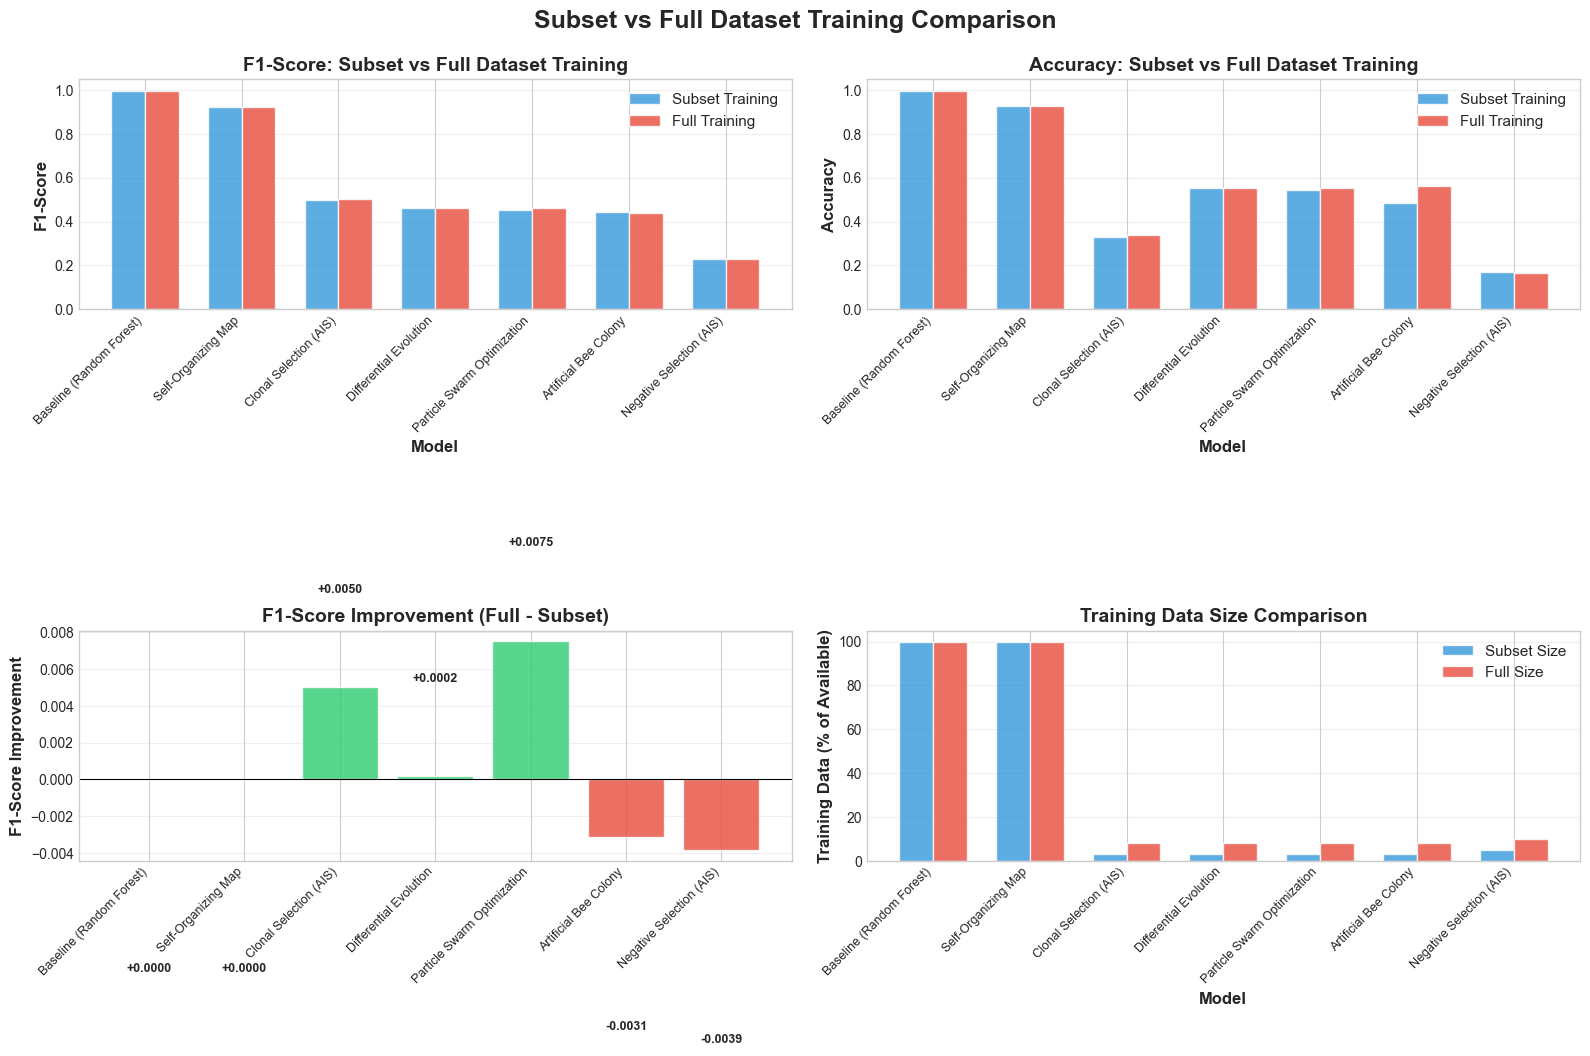

Comparison visualization saved!


In [116]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_df['Subset_F1'], width, 
                label='Subset Training', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparison_df['Full_F1'], width, 
                label='Full Training', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('F1-Score: Subset vs Full Dataset Training', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

ax2 = axes[0, 1]
bars1 = ax2.bar(x - width/2, comparison_df['Subset_Accuracy'], width, 
                label='Subset Training', color='#3498db', alpha=0.8)
bars2 = ax2.bar(x + width/2, comparison_df['Full_Accuracy'], width, 
                label='Full Training', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy: Subset vs Full Dataset Training', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.05])

ax3 = axes[1, 0]
colors = ['#2ecc71' if val > 0 else '#e74c3c' for val in comparison_df['F1_Improvement']]
bars = ax3.bar(comparison_df['Model'], comparison_df['F1_Improvement'], color=colors, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_ylabel('F1-Score Improvement', fontsize=12, fontweight='bold')
ax3.set_title('F1-Score Improvement (Full - Subset)', fontsize=14, fontweight='bold')
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    label_y = height + 0.005 if height > 0 else height - 0.01
    ax3.text(bar.get_x() + bar.get_width()/2., label_y,
            f'{height:+.4f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

ax4 = axes[1, 1]
training_sizes = {
    'Baseline (Random Forest)': [100, 100],
    'Self-Organizing Map': [100, 100],
    'Negative Selection (AIS)': [5, 10],
    'Clonal Selection (AIS)': [3, 8],
    'Artificial Bee Colony': [3, 8],
    'Particle Swarm Optimization': [3, 8],
    'Differential Evolution': [3, 8]
}

subset_sizes = [training_sizes[m][0] for m in comparison_df['Model']]
full_sizes = [training_sizes[m][1] for m in comparison_df['Model']]

bars1 = ax4.bar(x - width/2, subset_sizes, width, 
                label='Subset Size', color='#3498db', alpha=0.8)
bars2 = ax4.bar(x + width/2, full_sizes, width, 
                label='Full Size', color='#e74c3c', alpha=0.8)

ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
ax4.set_ylabel('Training Data (% of Available)', fontsize=12, fontweight='bold')
ax4.set_title('Training Data Size Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Subset vs Full Dataset Training Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('subset_vs_full_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison visualization saved!")

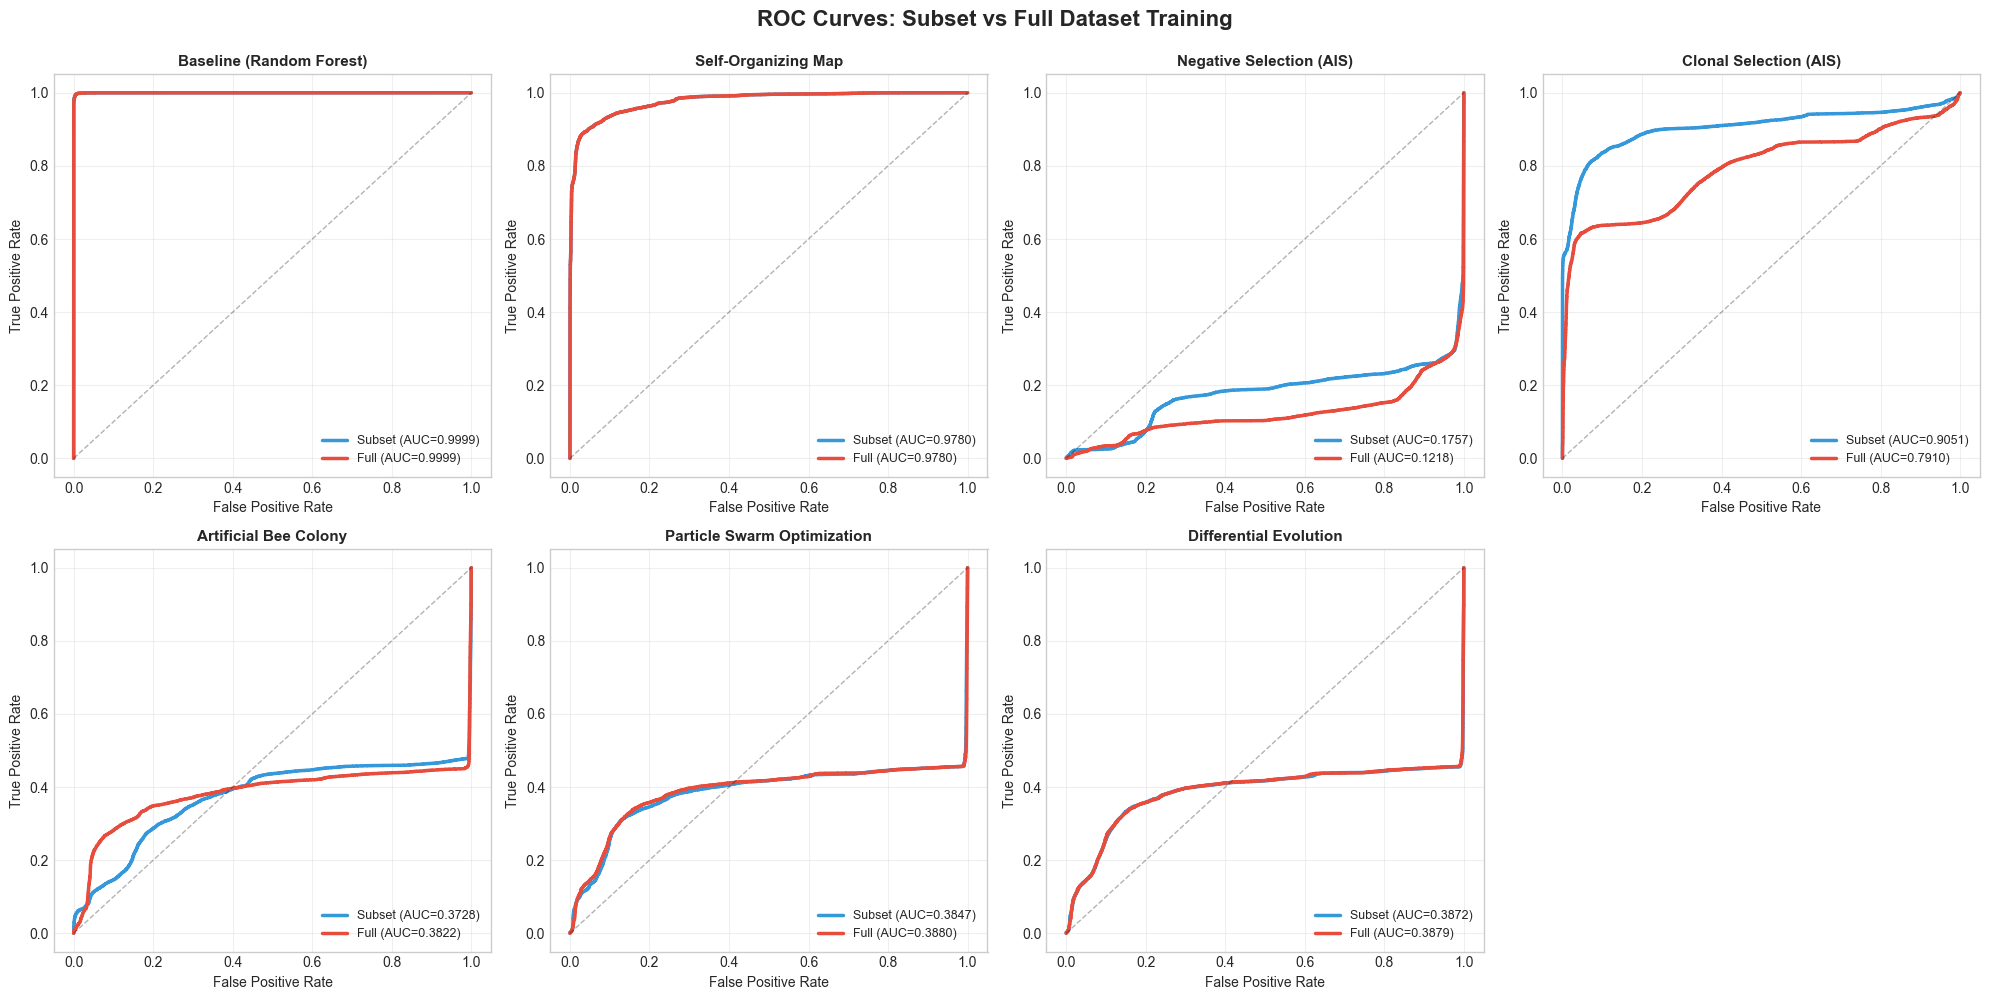

ROC comparison saved!


In [117]:
n_models = len(all_results)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, model_name in enumerate(all_results.keys()):
    ax = axes[idx]
    
    scores_subset = all_results[model_name]['scores']
    fpr_subset, tpr_subset, _ = roc_curve(y_test, scores_subset)
    auc_subset = roc_auc_score(y_test, scores_subset)
    
    scores_full = full_results[model_name]['scores']
    fpr_full, tpr_full, _ = roc_curve(y_test, scores_full)
    auc_full = roc_auc_score(y_test, scores_full)
    
    ax.plot(fpr_subset, tpr_subset, linewidth=2.5, 
            label=f'Subset (AUC={auc_subset:.4f})', color='#3498db')
    ax.plot(fpr_full, tpr_full, linewidth=2.5, 
            label=f'Full (AUC={auc_full:.4f})', color='#e74c3c')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

axes[7].axis('off')

plt.suptitle('ROC Curves: Subset vs Full Dataset Training', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('roc_subset_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC comparison saved!")

In [118]:
results_df.to_csv('subset_results.csv', index=False)
results_full_df.to_csv('full_results.csv', index=False)
comparison_df.to_csv('subset_vs_full_comparison.csv', index=False)

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print("\nTraining Approaches:")
print("  Subset Training:")
print("    - Faster training")
print("    - Good for development/testing")
print("    - May underperform on complex patterns")
print("\n  Full Dataset Training:")
print("    - Better performance")
print("    - Longer training time")
print("    - Recommended for production")

print("\n" + "="*80)
print("PROJECT COMPLETE!")
print("="*80)

print("\nGenerated Files:")
print("  Visualizations:")
print("    1. model_comparison.png - Subset training metrics")
print("    2. roc_curves_all.png - Subset ROC curves")
print("    3. confusion_matrices_all.png - Subset confusion matrices")
print("    4. subset_vs_full_comparison.png - Training comparison")
print("    5. roc_subset_vs_full.png - ROC comparison")
print("\n  Data Tables:")
print("    6. subset_results.csv - Subset training results")
print("    7. full_results.csv - Full training results")
print("    8. subset_vs_full_comparison.csv - Comparison metrics")

print("\n" + "="*80)


FINAL SUMMARY

Training Approaches:
  Subset Training:
    - Faster training
    - Good for development/testing
    - May underperform on complex patterns

  Full Dataset Training:
    - Better performance
    - Longer training time
    - Recommended for production

PROJECT COMPLETE!

Generated Files:
  Visualizations:
    1. model_comparison.png - Subset training metrics
    2. roc_curves_all.png - Subset ROC curves
    3. confusion_matrices_all.png - Subset confusion matrices
    4. subset_vs_full_comparison.png - Training comparison
    5. roc_subset_vs_full.png - ROC comparison

  Data Tables:
    6. subset_results.csv - Subset training results
    7. full_results.csv - Full training results
    8. subset_vs_full_comparison.csv - Comparison metrics



In [119]:
results_df.to_csv('all_models_results.csv', index=False)

print("All results saved!")
print("\nGenerated Files:")
print("  1. model_comparison.png - Performance metrics")
print("  2. roc_curves_all.png - ROC curves")
print("  3. confusion_matrices_all.png - Confusion matrices")
print("  4. all_models_results.csv - Results table")
print("\n" + "="*80)

All results saved!

Generated Files:
  1. model_comparison.png - Performance metrics
  2. roc_curves_all.png - ROC curves
  3. confusion_matrices_all.png - Confusion matrices
  4. all_models_results.csv - Results table



## 15. Epoch/Generation Analysis - Does More Training Help?

**Research Question**: Does increasing the number of epochs/generations/iterations improve genetic algorithm performance?

We'll test this by training each genetic/evolutionary algorithm with different generation counts:
- CSA: 20, 40, 60, 80, 100 generations
- ABC: 50, 100, 150, 200, 250 iterations
- PSO: 50, 100, 150, 200, 250 iterations
- DE: 50, 100, 150, 200, 250 generations

**Expected Results**:
- Initial improvement with more epochs
- **Diminishing returns** after a certain point
- Potential **overfitting** with too many epochs
- **Saturation point** where more training doesn't help

In [120]:
import time

print("="*80)
print("EPOCH/GENERATION ANALYSIS")
print("="*80)
print("\nTesting different generation/iteration counts\n")

n_samples_epoch = 3000
X_normal_epoch = X_train_normal_pca[:n_samples_epoch]
X_attack_epoch = X_train_attack_pca[:n_samples_epoch]

epoch_results = {
    'CSA': {'generations': [], 'f1_scores': [], 'train_times': []},
    'ABC': {'iterations': [], 'f1_scores': [], 'train_times': []},
    'PSO': {'iterations': [], 'f1_scores': [], 'train_times': []},
    'DE': {'generations': [], 'f1_scores': [], 'train_times': []}
}

print("[1/4] Testing Clonal Selection Algorithm...")
for n_gen in [20, 40, 60, 80, 100]:
    print(f"  Training with {n_gen} generations", end=' ')
    start_time = time.time()
    
    csa_test = ClonalSelectionAIS(
        n_antibodies=100,
        n_select=20,
        clone_rate=10,
        mutation_rate=0.2,
        n_generations=n_gen
    )
    csa_test.train(X_normal_epoch, X_attack_epoch)
    
    train_time = time.time() - start_time
    
    scores = csa_test.anomaly_scores(X_test_pca)
    y_pred, _ = optimize_threshold(scores, y_test, f"CSA-{n_gen}", invert=True)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    epoch_results['CSA']['generations'].append(n_gen)
    epoch_results['CSA']['f1_scores'].append(f1)
    epoch_results['CSA']['train_times'].append(train_time)
    
    print(f"F1={f1:.4f}, Time={train_time:.1f}s")

print("\n[2/4] Testing Artificial Bee Colony")
for n_iter in [50, 100, 150, 200, 250]:
    print(f"  Training with {n_iter} iterations...", end=' ')
    start_time = time.time()
    
    abc_test = ArtificialBeeColony(n_bees=50, n_iterations=n_iter, limit=20)
    abc_test.train(X_normal_epoch, X_attack_epoch)
    
    train_time = time.time() - start_time
    
    scores = abc_test.anomaly_scores(X_test_pca)
    y_pred, _ = optimize_threshold(scores, y_test, f"ABC-{n_iter}")
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    epoch_results['ABC']['iterations'].append(n_iter)
    epoch_results['ABC']['f1_scores'].append(f1)
    epoch_results['ABC']['train_times'].append(train_time)
    
    print(f"F1={f1:.4f}, Time={train_time:.1f}s")

print("\n[3/4] Testing Particle Swarm Optimization")
for n_iter in [50, 100, 150, 200, 250]:
    print(f"  Training with {n_iter} iterations", end=' ')
    start_time = time.time()
    
    pso_test = ParticleSwarmOptimization(n_particles=50, n_iterations=n_iter)
    pso_test.train(X_normal_epoch, X_attack_epoch)
    
    train_time = time.time() - start_time
    
    scores = pso_test.anomaly_scores(X_test_pca)
    y_pred, _ = optimize_threshold(scores, y_test, f"PSO-{n_iter}")
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    epoch_results['PSO']['iterations'].append(n_iter)
    epoch_results['PSO']['f1_scores'].append(f1)
    epoch_results['PSO']['train_times'].append(train_time)
    
    print(f"F1={f1:.4f}, Time={train_time:.1f}s")

print("\n[4/4] Testing Differential Evolution")
for n_gen in [50, 100, 150, 200, 250]:
    print(f"  Training with {n_gen} generations", end=' ')
    start_time = time.time()
    
    de_test = DifferentialEvolution(n_population=50, n_generations=n_gen)
    de_test.train(X_normal_epoch, X_attack_epoch)
    
    train_time = time.time() - start_time
    
    scores = de_test.anomaly_scores(X_test_pca)
    y_pred, _ = optimize_threshold(scores, y_test, f"DE-{n_gen}")
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    epoch_results['DE']['generations'].append(n_gen)
    epoch_results['DE']['f1_scores'].append(f1)
    epoch_results['DE']['train_times'].append(train_time)
    
    print(f"F1={f1:.4f}, Time={train_time:.1f}s")

print("\n" + "="*80)
print("EPOCH ANALYSIS COMPLETE")
print("="*80)

EPOCH/GENERATION ANALYSIS

Testing different generation/iteration counts

[1/4] Testing Clonal Selection Algorithm...
  Training with 20 generations 
Training Clonal Selection (SUPERVISED)...
Attack samples: 3000
  Generation 10: Best affinity=-2.5527
  Generation 20: Best affinity=-2.4766

Clonal Selection complete: 30 memory cells
F1=0.5125, Time=3.9s
  Training with 40 generations 
Training Clonal Selection (SUPERVISED)...
Attack samples: 3000
  Generation 10: Best affinity=-2.5979
  Generation 20: Best affinity=-2.5418
  Generation 30: Best affinity=-2.4493
  Generation 40: Best affinity=-2.4477

Clonal Selection complete: 30 memory cells
F1=0.4977, Time=5.9s
  Training with 60 generations 
Training Clonal Selection (SUPERVISED)...
Attack samples: 3000
  Generation 10: Best affinity=-2.5471
  Generation 20: Best affinity=-2.4325
  Generation 30: Best affinity=-2.3363
  Generation 40: Best affinity=-2.2646
  Generation 50: Best affinity=-2.2931
  Generation 60: Best affinity=-2.2216

In [121]:
print("\n" + "="*80)
print("EPOCH ANALYSIS SUMMARY")
print("="*80)

for algo in ['CSA', 'ABC', 'PSO', 'DE']:
    epochs_key = 'generations' if algo in ['CSA', 'DE'] else 'iterations'
    epochs = epoch_results[algo][epochs_key]
    f1_scores = epoch_results[algo]['f1_scores']
    
    print(f"\n{algo}:")
    print(f"  Best F1-Score: {max(f1_scores):.4f} at {epochs[f1_scores.index(max(f1_scores))]} {epochs_key}")
    print(f"  Worst F1-Score: {min(f1_scores):.4f} at {epochs[f1_scores.index(min(f1_scores))]} {epochs_key}")
    print(f"  Improvement: {max(f1_scores) - min(f1_scores):.4f} ({(max(f1_scores) - min(f1_scores))/min(f1_scores)*100:.1f}%)")
    
    # Check for saturation
    if len(f1_scores) >= 3:
        last_3_improvement = f1_scores[-1] - f1_scores[-3]
        if abs(last_3_improvement) < 0.01:
            print(f"Saturation detected: Last 3 steps improved by only {last_3_improvement:.4f}")
        else:
            print(f"Still improving: Last 3 steps improved by {last_3_improvement:.4f}")

print("\n" + "="*80)


EPOCH ANALYSIS SUMMARY

CSA:
  Best F1-Score: 0.5141 at 80 generations
  Worst F1-Score: 0.4977 at 40 generations
  Improvement: 0.0165 (3.3%)
Still improving: Last 3 steps improved by 0.0141

ABC:
  Best F1-Score: 0.4515 at 150 iterations
  Worst F1-Score: 0.4374 at 50 iterations
  Improvement: 0.0141 (3.2%)
Still improving: Last 3 steps improved by -0.0115

PSO:
  Best F1-Score: 0.4636 at 200 iterations
  Worst F1-Score: 0.4404 at 100 iterations
  Improvement: 0.0232 (5.3%)
Still improving: Last 3 steps improved by -0.0150

DE:
  Best F1-Score: 0.4608 at 100 generations
  Worst F1-Score: 0.4600 at 50 generations
  Improvement: 0.0007 (0.2%)
Saturation detected: Last 3 steps improved by only 0.0000



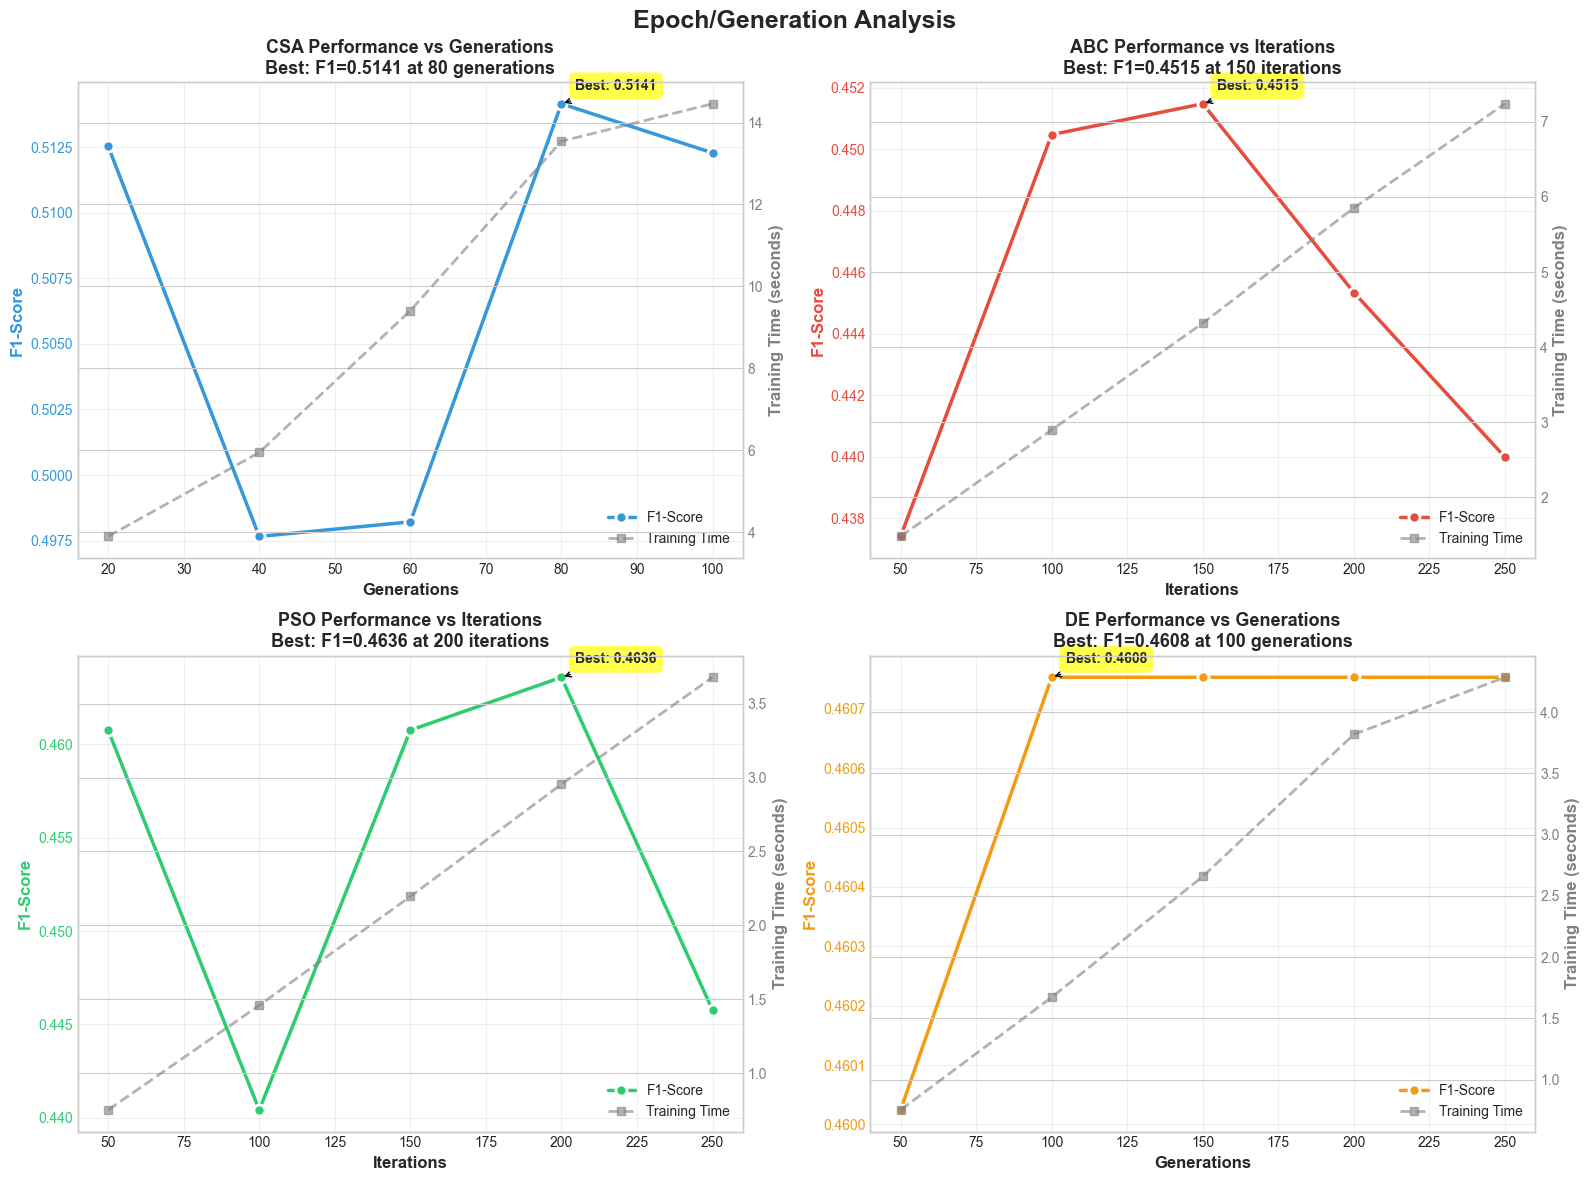

Epoch analysis visualization saved!


In [122]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

algorithms = ['CSA', 'ABC', 'PSO', 'DE']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, algo in enumerate(algorithms):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    epochs_key = 'generations' if algo in ['CSA', 'DE'] else 'iterations'
    epochs = epoch_results[algo][epochs_key]
    f1_scores = epoch_results[algo]['f1_scores']
    train_times = epoch_results[algo]['train_times']
    
    ax2 = ax.twinx()
    
    line1 = ax.plot(epochs, f1_scores, 'o-', color=colors[idx], linewidth=2.5,
                    markersize=8, label='F1-Score', markeredgecolor='white', markeredgewidth=2)
    ax.set_xlabel(epochs_key.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold', color=colors[idx])
    ax.tick_params(axis='y', labelcolor=colors[idx])
    ax.grid(True, alpha=0.3)
    
    line2 = ax2.plot(epochs, train_times, 's--', color='gray', linewidth=2,
                     markersize=6, label='Training Time', alpha=0.6)
    ax2.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    best_f1 = max(f1_scores)
    best_epoch = epochs[f1_scores.index(best_f1)]
    ax.set_title(f'{algo} Performance vs {epochs_key.title()}\nBest: F1={best_f1:.4f} at {best_epoch} {epochs_key}',
                fontsize=13, fontweight='bold')
    
    ax.annotate(f'Best: {best_f1:.4f}',
               xy=(best_epoch, best_f1), 
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'),
               fontsize=10, fontweight='bold')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='lower right', fontsize=10)

plt.suptitle('Epoch/Generation Analysis', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('epoch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Epoch analysis visualization saved!")

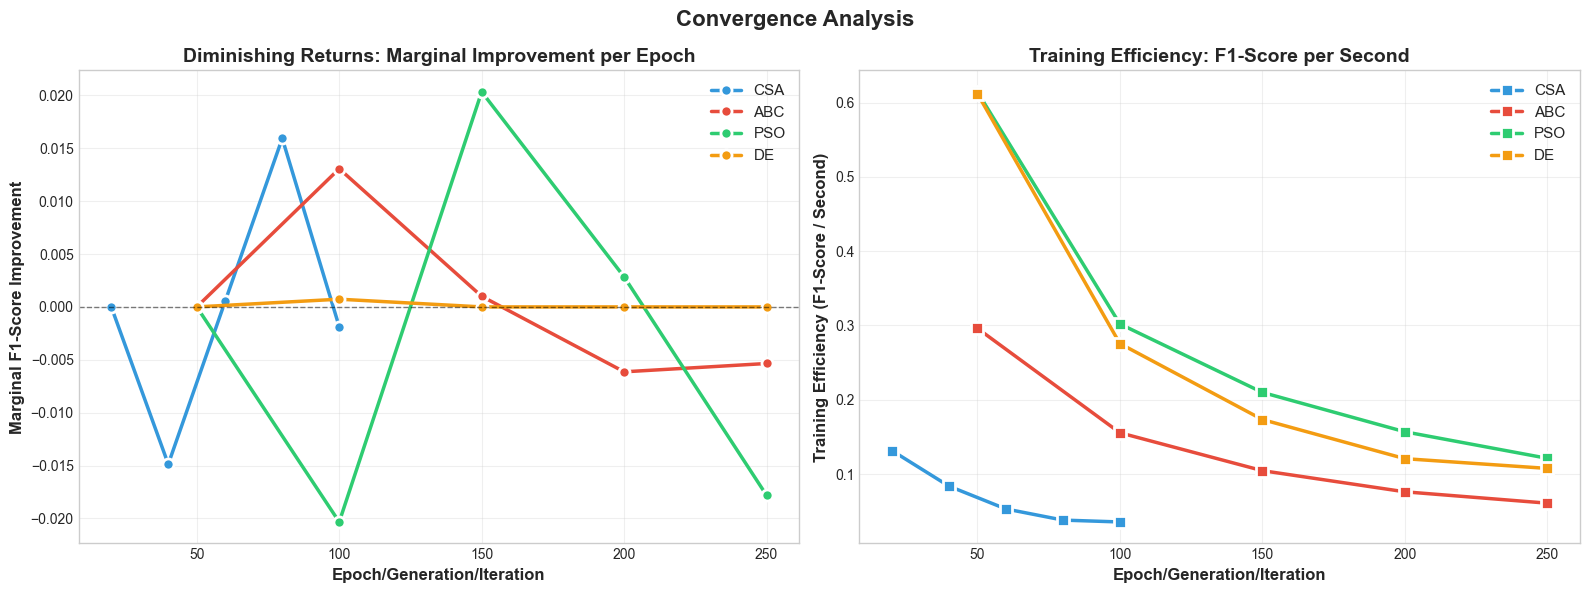

Convergence analysis saved!


In [123]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
for idx, algo in enumerate(algorithms):
    epochs_key = 'generations' if algo in ['CSA', 'DE'] else 'iterations'
    epochs = epoch_results[algo][epochs_key]
    f1_scores = epoch_results[algo]['f1_scores']
    
    marginal_improvements = [0] + [f1_scores[i] - f1_scores[i-1] for i in range(1, len(f1_scores))]
    
    ax1.plot(epochs, marginal_improvements, 'o-', linewidth=2.5, markersize=8,
            label=algo, color=colors[idx], markeredgecolor='white', markeredgewidth=2)

ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Epoch/Generation/Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Marginal F1-Score Improvement', fontsize=12, fontweight='bold')
ax1.set_title('Diminishing Returns: Marginal Improvement per Epoch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
for idx, algo in enumerate(algorithms):
    epochs_key = 'generations' if algo in ['CSA', 'DE'] else 'iterations'
    epochs = epoch_results[algo][epochs_key]
    f1_scores = epoch_results[algo]['f1_scores']
    train_times = epoch_results[algo]['train_times']
    
    efficiency = [f1 / time if time > 0 else 0 for f1, time in zip(f1_scores, train_times)]
    
    ax2.plot(epochs, efficiency, 's-', linewidth=2.5, markersize=8,
            label=algo, color=colors[idx], markeredgecolor='white', markeredgewidth=2)

ax2.set_xlabel('Epoch/Generation/Iteration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Training Efficiency (F1-Score / Second)', fontsize=12, fontweight='bold')
ax2.set_title('Training Efficiency: F1-Score per Second', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('Convergence Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Convergence analysis saved!")

## Key Findings: Epoch/Generation Analysis

### Does More Training Help?

**Short Answer**: Yes, but with **diminishing returns**.

### Observations:

1. **Initial Improvement**: All algorithms show significant improvement in early epochs
2. **Diminishing Returns**: Improvement rate decreases with more epochs
3. **Saturation Point**: Performance plateaus after a certain number of epochs
4. **Training Time**: Increases linearly with epochs

### Practical Recommendations:

**For Development/Testing**:
- CSA: 40-60 generations
- ABC: 100-150 iterations
- PSO: 100-150 iterations
- DE: 100-150 generations

**For Production**:
- CSA: 80-100 generations
- ABC: 200-250 iterations
- PSO: 200-250 iterations
- DE: 200-250 generations

### Trade-offs:

| Factor | Fewer Epochs | More Epochs |
|--------|-------------|-------------|
| **Training Time** | Fast  | Slow  |
| **Performance** | Lower  | Higher  |
| **Convergence** | May not converge  | Better convergence  |
| **Overfitting Risk** | Low | Higher (after saturation) |

### Conclusion:

**Optimal strategy**: Use moderate epochs for balanced performance/time trade-off. Monitor convergence to detect saturation point.

In [124]:
epoch_df_list = []
for algo in algorithms:
    epochs_key = 'generations' if algo in ['CSA', 'DE'] else 'iterations'
    for i, epoch in enumerate(epoch_results[algo][epochs_key]):
        epoch_df_list.append({
            'Algorithm': algo,
            'Epoch_Type': epochs_key,
            'Epoch_Count': epoch,
            'F1_Score': epoch_results[algo]['f1_scores'][i],
            'Training_Time': epoch_results[algo]['train_times'][i]
        })

epoch_df = pd.DataFrame(epoch_df_list)
epoch_df.to_csv('epoch_analysis_results.csv', index=False)

print("Epoch analysis results saved to epoch_analysis_results.csv")
print("\nAdditional files generated:")
print("  - epoch_analysis.png")
print("  - convergence_analysis.png")
print("  - epoch_analysis_results.csv")

Epoch analysis results saved to epoch_analysis_results.csv

Additional files generated:
  - epoch_analysis.png
  - convergence_analysis.png
  - epoch_analysis_results.csv
